***
<font size="2.5" color="#008385">15-288: Machine Learning in a Nutshell, *CMU-Qatar,* Spring'24<br><p></font>
    
<font size="+3" color="#008385"> **Team 1:** Asian Faces Classification using Machine Learning </font>   
<br><p>
<center><font size="+2.9" color="red">Presented by Phat Diep, Sangyoon Lim </font></center>

***

<font size="3.5">This project aims to explore the feasibility and accuracy of classifying **Asian's nationalities** using Machine Learning models **i.e. convolutional neural networks**. The prevailing models for facial recognition are **dominated by Westerners**, while **Asians are underrepresented**, resulting in lesser accuracy in recognizing Asian heritage than their Western counterparts (Xiong et al., 2019). For the availability of data, we use **female** images for classification. </font>

#### Keywords: CNN, Classification, Asian Face Dataset, Racial bias.

## <font color ="blue"> D4. QuAM (Query Answering Machine) </font>

#### **Input**: Image
#### **Output**: China, Japan, Korea, Phillipines, Vietnam

**Loading the model**

In [126]:
import os
MODEL_DIR = "model"
MODEL = "resnet" #resnet, convnext
checkpoint_path = os.path.join(os.getcwd() , MODEL_DIR, MODEL, "model.pth")

**Select image**

In [ ]:
import warnings
from PyQt5.QtWidgets import QApplication, QFileDialog

# Suppress all warnings (optional)
warnings.filterwarnings("ignore")
def select_image():
    '''
    Output: select_image will popup a window using PyQt5, return the selected image path. 
    '''
    # Create an application object
    app = QApplication(sys.argv)
    
    # Open the file dialog to choose an image
    file_dialog = QFileDialog()
    file_path, _ = file_dialog.getOpenFileName(
        caption="Select an Image",
        filter="Image Files (*.png *.jpg *.jpeg)"
    )
    
    return file_path

This section processes the images by extracting faces using **OpenCV's Haar cascade classifier**. 

Extracted faces are saved in a designated subdirectory, aiding in focusing on relevant data for facial recognition tasks.

In [ ]:
import cv2

cascade_path = os.path.join(os.getcwd(),"cv2/haarcascade_frontalface_default.xml")
def detect_faces(image_path):
    '''Input: Image
       Output: RGB numpy array
    '''
    image = cv2.imread(image_path) # Load the image with OpenCV
    # Convert to grayscale (Haar cascade requires grayscale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use Haar cascade to detect faces
    face_cascade = cv2.CascadeClassifier(cascade_path)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Extract face regions and convert them to PIL Images
    face_images = []
    for (x, y, w, h) in faces:
        face_image = image[y:y + h, x:x + w]
        face_images.append(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)) #cv2.imread load image as BGR, ensure to convert it to RGB
    return face_images

In [ ]:
import torch
import sys
import numpy as np
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt

def QuAM ():
    # Define the transformation pipeline
    transform_pipeline = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ])

    # Load the model from the specified checkpoint
    device = torch.device('cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if MODEL == "convnext":
        model = torchvision.models.convnext_small(weights=None, num_classes=5).to(device)
    elif MODEL == "resnet": 
        model = torchvision.models.resnet34(weights=None, num_classes=5).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load and transform a sample image
    image_path = select_image()
    face_images = detect_faces(image_path)  # Extract faces from the image

    if not face_images:
        print("No faces found in the image.")
    else:
        # Process each extracted face
        for face_image in face_images:
            face_image = Image.fromarray(face_image.astype(np.uint8))
            transformed_face = transform_pipeline(face_image)
            input_tensor = transformed_face.unsqueeze(0)  # Add batch dimension

            # Classify the face with the pre-trained model
            with torch.no_grad():
                output = model(input_tensor)

            # Get probabilities using softmax
            probabilities = torch.softmax(output, dim=1)
            max_index = torch.argmax(probabilities, dim=1)
            class_labels = ["China", "Japan", "Korea", "Philippines", "Vietnam"]

            # Get the corresponding class label
            most_likely_class = class_labels[max_index.item()]

            prob_list = probabilities[0].tolist()
            print("Most likely class:", most_likely_class)
            # Print the probabilities with their corresponding class labels
            print("Probabilities:")
            for label, prob in zip(class_labels, prob_list):
                print(f"{label}: \t{prob:.2f}")
            
            # Display the transformed face image
            plt.imshow(transformed_face.permute(1, 2, 0))
            plt.title(f"Model Predict: {most_likely_class}")
            plt.axis('off') 
            plt.show()
            
# Call the function            
QuAM()

## <font color="blue">D3.0 Data Sets </font>

In [4]:
import torch
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt

In [5]:
cuda = torch.device('cuda')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
DATA_DIR    = "./data" 

In [7]:
from torch.utils.data import DataLoader, random_split
import torchvision
import torch

config = {'batch_size': 64,'image_size':(128,128)}
original = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # This is required to work with tensors in DataLoader
])
original_dataset      = torchvision.datasets.ImageFolder(DATA_DIR, transform=original)


In [8]:
import os

# Get the list of subdirectories (each representing a class)
subdirectories = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]

# Iterate over each subdirectory and print its name and the length of its contents
for subdir in subdirectories:
    subdir_name = os.path.basename(subdir)
    num_files = len(os.listdir(subdir))
    print(f"Folder: {subdir_name}, \t Length: {num_files}")


Folder: China, 	 Length: 1158
Folder: Japan, 	 Length: 1031
Folder: Korea, 	 Length: 1826
Folder: Vietnam, 	 Length: 968
Folder: Phillipines, 	 Length: 1473


Data is imbalanced. I will use the oversampling method

In [9]:
from torch.utils.data import DataLoader
import torchvision
import torch

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(config['image_size']),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    ]) 
transformed_dataset   = torchvision.datasets.ImageFolder(DATA_DIR, transform = transforms)

train_ratio = 0.8
train_size = int(train_ratio * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = random_split(transformed_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 2, 
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle       = True,
                                           num_workers = 2
                                           )

### Total number of training images = 5125

In [9]:
total_images = len(original_dataset)

print("Total number of images:", total_images)

Total number of images: 6456


In [10]:
# Get the total number of samples in each dataset
total_train_samples = len(train_dataset)  # Total training samples
total_val_samples = len(valid_dataset)  # Total validation samples

print("Total training samples:", total_train_samples)
print("Total validation samples:", total_val_samples)

Total training samples: 5164
Total validation samples: 1292


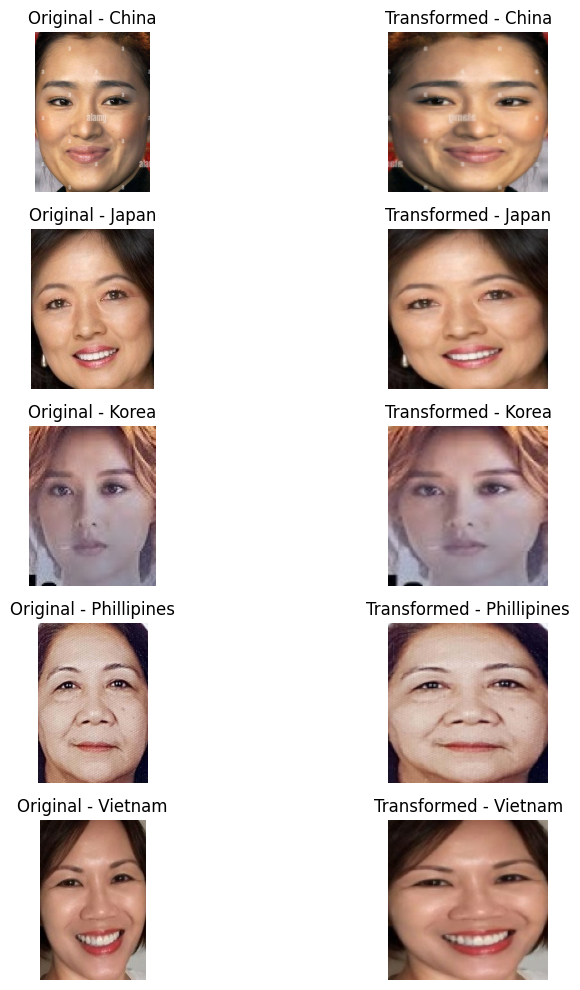

In [11]:
# batch = 1
def get_class_indices(dataset):
    class_indices = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_name = dataset.classes[label]
        if class_name not in class_indices:
            class_indices[class_name] = i
        if len(class_indices) == len(dataset.classes):
            break
    return class_indices

# Get the indices for one image per class
class_indices = get_class_indices(original_dataset)  # Same indices for both datasets

# Fetch the same image from both original and transformed datasets
original_images_by_class = {}
transformed_images_by_class = {}

for class_name, index in class_indices.items():
    # Get the original image
    original_image, _ = original_dataset[index]
    original_images_by_class[class_name] = original_image

    # Get the transformed image
    transformed_image, _ = transformed_dataset[index]
    transformed_images_by_class[class_name] = transformed_image

# Plot original and transformed images side-by-side for each class
num_classes = len(original_images_by_class)
fig, ax = plt.subplots(num_classes, 2, figsize=(10, num_classes * 2))

for i, class_name in enumerate(original_images_by_class.keys()):
    # Original image
    original_image = original_images_by_class[class_name]
    original_np = original_image.permute(1, 2, 0).detach().to("cpu").numpy()  # Convert tensor to NumPy
    original_np = (original_np - original_np.min()) / (original_np.max() - original_np.min())  # Normalize to [0, 1]
    ax[i, 0].imshow(original_np)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f"Original - {class_name}")

    # Transformed image
    transformed_image = transformed_images_by_class[class_name]
    transformed_np = transformed_image.permute(1, 2, 0).detach().to("cpu").numpy()  # Convert to NumPy
    transformed_np = (transformed_np - transformed_np.min()) / (transformed_np.max() - transformed_np.min())  # Normalize
    ax[i, 1].imshow(transformed_np)
    ax[i, 1].axis('off')
    ax[i, 1].set_title(f"Transformed - {class_name}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()  # Display the plot


## <font color="blue">D3.1.0 K-NN (N=5) Model Training </font>

* **<font color="blue">Baseline model: </font>** We leverage on the HW2 assignment to conduct such a "complex task" using **K-NN (N=5)** with **HOG** feature extraction
* **<font color="blue">Result: </font>** Accuracy = 0.35 Not too bad, but can we do better?

In [4]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import numpy as np
import multiprocessing


# Function to calculate the mean cross-validation score
def calculate_cv_score(params, X_train, y_train):
    knn = KNeighborsClassifier(**params)
    scores = cross_val_score(knn, X_train, y_train, cv=3)
    return np.mean(scores)


# Timeout function to run code in a separate process
def time_limited_function(func, args=(), kwargs=None, timeout=30):
    if kwargs is None:
        kwargs = {}

    # Start a new process to execute the function
    with multiprocessing.Pool(1) as pool:
        result = pool.apply_async(func, args=args, kwds=kwargs)

        try:
            # Get the result with a timeout
            return result.get(timeout=timeout)
        except multiprocessing.TimeoutError:
            return None  # If the function times out, return None


# Function to find the best KNN with tqdm progress
def find_best_knn(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_neighbors': range(1, 16),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }

    # Create the grid of parameters
    parameter_grid = list(ParameterGrid(param_grid))

    # Initialize tqdm progress bar
    tqdm_bar = tqdm(parameter_grid, desc="Grid Search Progress")

    # Best score and best model tracking
    best_score = -np.inf
    best_params = None

    # Loop through parameter combinations with timeout check
    for params in tqdm_bar:
        # Execute the function with a timeout
        mean_score = time_limited_function(
            calculate_cv_score, args=(params, X_train, y_train)
        )

        # Check if the score was obtained within the timeout period
        if mean_score is not None:
            # Update best score and parameters if the new score is better
            if mean_score > best_score:
                best_score = mean_score
                best_params = params

    # Create the best model with the optimal parameters
    best_model = KNeighborsClassifier(**best_params)
    best_model.fit(X_train, y_train)  # Fit the best model to the full training data
    
    return best_model


In [5]:
import cv2
import numpy as np
from skimage import feature, filters

# Sobel edge detection
def apply_sobel(image):
    sobel_x = filters.sobel_h(image)
    sobel_y = filters.sobel_v(image)
    sobel_edges = np.hypot(sobel_x, sobel_y)
    return sobel_edges

# Canny edge detection
def apply_canny(image, threshold1=100, threshold2=200):
    canny_edges = cv2.Canny(image, threshold1, threshold2)
    return canny_edges

# SIFT feature detection
def apply_sift(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Roberts edge detection
def apply_roberts(image):
    roberts_edges = filters.roberts(image)
    return roberts_edges


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

config = {'image_size':(128,128)}

EXPECTED_FEATURE_LENGTH = 128 * 128  # Sobel, Canny, and Roberts length

# Load images from the dataset and return features and labels
def load_and_preprocess_dataset(base_dir, target_size):
    images = []
        labels = []
    label_dirs = [os.path.join(base_dir, label) for label in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, label))]
    for label in label_dirs:
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
                if img is not None:
                    # Resize to a consistent size
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)
    return images, labels
    
# Feature extraction for a single image
def extract_all_features(image,target_size):
    sobel_features = apply_sobel(image).flatten()
    canny_features = apply_canny(image).flatten()
    roberts_features = apply_roberts(image).flatten()
    # SIFT descriptors with validation
    sift = cv2.SIFT_create()
    keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    if sift_descriptors is None:
        # If SIFT fails, create a default descriptor with consistent length
        sift_flattened = np.zeros((EXPECTED_FEATURE_LENGTH,))
    else:
        sift_flattened = sift_descriptors.flatten()
        
    # Concatenate all features into a single array
    combined_features = np.concatenate([
        sobel_features,
        canny_features,
        sift_flattened,
        roberts_features
    ])
    return combined_features

# The main function that uses feature extraction and trains a KNN model
def main(base_dir):
    # Load dataset
    images, labels = load_and_preprocess_dataset(base_dir,config['image_size'])

    # Extract features from all images
    features = np.array([extract_all_features(img, config['image_size']) for img in tqdm(images, desc="Extracting Features")])

    # Encode labels to numerical values
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

    # Find the best KNN model
    best_knn = find_best_knn(X_train, y_train)

    # Print the best model and evaluate its accuracy on the test set
    print("Best KNN Model:", best_knn)
    print("Test Score:", best_knn.score(X_test, y_test))

# Provide the base directory of your training dataset
dataset_base_directory = os.path.join(os.getcwd(),'data')
main(dataset_base_directory)

Grid Search Progress: 100%|███████████████████████████████| 90/90 [29:39<00:00, 19.77s/it]


Best KNN Model: KNeighborsClassifier(metric='euclidean', n_neighbors=15)
Test Score: 0.2803304078471864


## <font color="blue">D3.1.1 C-NN Model Training </font>

In [10]:
def train(model, dataloader, optimizer, criterion, scheduler):
    '''
    This function is used for Forward and Backpropagation on the training data (train_loader)
    Output: train accuracy, train loss
    '''
    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast(): # This implements mixed precision.
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [11]:
def validate(model, dataloader, criterion):
    '''
    This function is used for Forward and Backpropagation on the test/validation data (valid_loader)
    Output: train accuracy, train loss
    '''

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [12]:
def save_model(checkpoint_path, epoch, model, optimizer,train_acc,train_loss,val_acc,val_loss):
    '''
    Save model as pytorch checkpoint'.pth' for C-NN model
    '''
    # checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{}.pth'.format(epoch))
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'scheduler_state_dict':scheduler.state_dict(),
        'train_acc': train_acc,
        'val_loss': val_loss,
        'train_loss': train_loss
    }, checkpoint_path)
    print("Checkpoint saved at:", checkpoint_path)

In [13]:
import os
import numpy as np
import math
from tqdm import tqdm

def CNN_trainer(model,checkpoint_dir):
    '''
    Output: CNN-model optimizer with best_class_acc (% accuracy, epoch number) 
    and list of [train accuracy, train loss, validation accuracy, validation loss, and learning rate].
    '''
    best_class_acc = {'acc'  : 0,
                      'epoch': 0 } 
    # Initialize lists to store data for plotting
    train_acc_history = np.zeros(config['epochs'])
    train_loss_history = np.zeros(config['epochs'])
    val_acc_history = np.zeros(config['epochs'])
    val_loss_history = np.zeros(config['epochs'])
    lr_history = np.zeros(config['epochs'])

    # Example training loop
    for epoch in tqdm(range(config['epochs'])):
        curr_lr = float(optimizer.param_groups[0]['lr'])
        train_acc, train_loss = train(model, train_loader, optimizer, criterion, scheduler)
        val_acc, val_loss = validate(model, valid_loader, criterion)

        # Store accuracy and loss in respective lists
        train_acc_history[epoch] = train_acc
        train_loss_history[epoch] = train_loss
        val_acc_history[epoch] = val_acc
        val_loss_history[epoch] = val_loss
        lr_history[epoch] = curr_lr
    
        print("\nEpoch {}/{}".format(epoch + 1, config['epochs']))
        print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc, train_loss, curr_lr))
        print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

        scheduler.step(val_loss)

        # Save best classification model
        if val_acc >= best_class_acc['acc']:
            best_class_acc ['acc'] = val_acc
            best_class_acc ['epoch'] = epoch
            checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{}.pth'.format(epoch))
            save_model(checkpoint_path, epoch, model, optimizer, train_acc, train_loss,val_acc, val_loss  )

        # Stop if NaN is detected in validation loss
        if math.isnan(val_loss):
            break

    metrics = np.vstack([train_acc_history, train_loss_history, val_acc_history, val_loss_history,lr_history])
    return best_class_acc,metrics

In [14]:
import matplotlib.pyplot as plt

def plot_learning_loss (epochs,metrics):
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))

    # Plot training and validation accuracy
    ax[0].plot(range(1, epochs + 1), metrics[0], label='Train Accuracy')
    ax[0].plot(range(1, epochs + 1), metrics[2], label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_title('Learning Curve')
    ax[0].legend()

    # Plot training and validation loss
    ax[1].plot(range(1, epochs + 1), metrics[1], label='Train Loss')
    ax[1].plot(range(1, epochs + 1), metrics[3], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Loss Curve')
    ax[1].legend()

    ax[2].plot(range(1, epochs + 1), metrics[4], label='Train Loss')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Learning rate')
    ax[2].set_title('Learning Curve')
    ax[2].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()




In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model,checkpoint_dir,cktp):
    # Load the model and move it to the device
    best_model_path = os.path.join(checkpoint_dir, f'model_epoch_{cktp}.pth')
    state_dict = torch.load(best_model_path)  # Load the state dict
    model.load_state_dict(state_dict['model_state_dict'])  # Load the state dict into the model

    # Move the model to the correct device
    model.to(device)
    model.eval()  # Ensure the model is in evaluation mode

    # Get the true labels and predictions from the validation set, ensuring tensors are on the correct device
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)  # Move images to the same device as the model
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())  # Collect true labels
            pred_labels.extend(predicted.cpu().numpy())  # Collect predictions

    # Create a confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    # Plot the confusion matrix
    ConfusionMatrixDisplay(conf_matrix).plot(
        cmap=plt.cm.Blues,
        colorbar=True,
        values_format='d'  # Show integer values in cells
    )
    plt.title("Confusion Matrix")
    plt.show()
    return conf_matrix

## <font color="blue">D.3.1.2 ResNet34 (Residual Network) </font>
1. <font color = "blue">**Citation:**</font> **(Kaiming He et al., 2015) Deep Residual Learning for Image Recognition by Microsoft Research** 
2. <font color = "blue">**Key Idea:**</font>  As a network becomes **deeper** (i.e., with more layers), its performance can degrade or stagnate, rather than improving. 
3. <font color = "blue">**Solution:**</font> "residual connections" or "skip connections" that allow the network to skip layers. This alleviates the vanishing gradient problem in very deep networks, enabling much deeper architectures without degradation in performance.
4. <font color = "blue">**Documentation:**</font> https://arxiv.org/pdf/1512.03385
5. <font color = "blue">**Result:**</font> Accuracy = 0.48

In [16]:
config = {
    'batch_size': 64, 
    'lr': 4e-4, 
    'epochs': 50, 
    'weight_decay': 0.0005, 
    'momentum': 0.9, 
    'dropout':0.1, 
    'label_smoothing': 0.1,
}

### <font color="blue">Deep Learning Layers Details: </font>

1. **batch_size**: We choose batch size as power of 2 typically yield better result, we choose **64** because that the highest our computer can get. (safety)
1. **lr (Learning Rate)** = 0.0004: the intital step size at each iteration toward a minimum of the loss function.
1. **epochs**: At first we use 200, but after that we found at around 50, our model converged.
1. **weight_decay**: A regularization technique 
1. **momentum**: Helps accelerate gradients vectors in the right direction, make it faster to converge 
1. **dropout**:  Another regularization technique to reduce overfitting at the last layer
1. **label_smoothing**: A technique for model uncertainty to feed into loss function (discussed later in Model Pipelined)

In [22]:
device = torch.device("cuda")
resnet34 = torchvision.models.resnet34(weights=None,num_classes=5).to(device)

In [23]:
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from typing import Any, Callable, List, Optional, Type, Union
from functools import partial

***
### <font color="blue">**Resnet Construction Layers Detail** </font>

### <font color="green">Initial Convolution and Pooling </font>
1. **Conv2d-1 and BatchNorm2d-2(extracting features)**: The initial convolutional layer and batch normalization prepare the input by extracting initial features and normalizing them, which helps in accelerating the training.
1. **ReLU-3 and MaxPool2d-4(activation)**: Activation and pooling further process these features, adding non-linearity and reducing spatial dimensions, respectively, to condense the information
### <font color="green">Residual Blocks  </font>
1. **Conv2d, BatchNorm2d, ReLU** : Each block contains two sequences of convolution, batch normalization, and ReLU layers. The convolutional layers further extract features at different levels of complexity.
### <font color="green">Final Layers</font>
1. **AdaptiveAvgPool2d-123**: This layer performs global average pooling by reducing each feature map to a single average value, thus flattening the output while retaining the most essential information from each feature map.
1. **Linear-124**: A fully connected layer that maps the pooled features into the final classification scores for 5 classes.


***

In [24]:
from torchsummary import summary

# 3 channels, 128 x 128 dimensions
summary(resnet34, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [25]:
# Directory to save checkpoints
checkpoint_dir = 'ckpts_resnet'
os.makedirs(checkpoint_dir, exist_ok=True)
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
ckpt_classification = f'checkpoint_classification_{timestamp}.pth'

### <font color = "blue"> Key Components of a Deep Learning Training Pipeline</font>
1. **<font color = "blue">Loss Function:</font>** **CrossEntropyLoss**
   * Reason: Prevent overfitting and improve model generalization.
   * Action: I introduce label_smoothing=0.01 to the true labels, prevent overfiting
1. **<font color = "blue">Optimizer:</font>** **Adam**
   * Reason: A much greater improvement from Stochastic Gradient Descent (SGD) because of its adaptive learning rate, before it makes me run to **100** epoch to **converge**
1. **<font color = "blue">Learning Rate Scheduler:</font>** **ReduceLROnPlateau**
   * Reason: It lowers the learning rate when a metric (e.g., validation loss) has stopped improving for a specified number of epochs.
1. **<font color = "blue">Scaler:</font>** **GradScaler**
   * Reason: It allows model to be trained faster

In [26]:
# --------------------------------------------------- #
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# --------------------------------------------------- #

# Defining Optimizer

optimizer = torch.optim.SGD(resnet34.parameters(),
                            lr=config['lr'],
                            momentum=config['momentum'],
                            weight_decay=config['weight_decay'])

# --------------------------------------------------- #

# Defining Scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
# --------------------------------------------------- #

# Defining Scaler

scaler = torch.cuda.amp.GradScaler()

# --------------------------------------------------- #

In [27]:
resnet_34 = CNN_trainer(resnet34,checkpoint_dir)

Train:   0%| | 0/81 [00:00<?, ?it/s, acc=28.1250%, loss=1.6286, lr=0.0004, num_correct=18]/data1/tnbui/phat/phat/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Val:   0%|                                                         | 0/21 [00:00<?, ?it/s]/data1/tnbui/phat/phat/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



Epoch 1/50
	Train Acc 28.8002%	Train Loss 1.6018	 Learning Rate 0.0004000
Val Acc (Classification) 22.7679%	 Val Loss (Classification) 1.6310


  2%|█                                                     | 1/50 [00:05<04:33,  5.58s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_0.pth



Epoch 2/50
	Train Acc 31.8287%	Train Loss 1.5714	 Learning Rate 0.0004000
Val Acc (Classification) 31.7708%	 Val Loss (Classification) 1.5668


  4%|██▏                                                   | 2/50 [00:10<04:16,  5.35s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_1.pth



Epoch 3/50
	Train Acc 32.6389%	Train Loss 1.5559	 Learning Rate 0.0004000
Val Acc (Classification) 33.3333%	 Val Loss (Classification) 1.5397


  6%|███▏                                                  | 3/50 [00:15<04:07,  5.27s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_2.pth


  8%|████▎                                                 | 4/50 [00:20<03:54,  5.11s/it]


Epoch 4/50
	Train Acc 34.2014%	Train Loss 1.5375	 Learning Rate 0.0004000
Val Acc (Classification) 33.1845%	 Val Loss (Classification) 1.5326



Epoch 5/50
	Train Acc 35.9568%	Train Loss 1.5198	 Learning Rate 0.0004000
Val Acc (Classification) 35.7887%	 Val Loss (Classification) 1.5118


 10%|█████▍                                                | 5/50 [00:25<03:50,  5.12s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_4.pth



Epoch 6/50
	Train Acc 37.1528%	Train Loss 1.5003	 Learning Rate 0.0004000
Val Acc (Classification) 38.8393%	 Val Loss (Classification) 1.4866


 12%|██████▍                                               | 6/50 [00:31<03:46,  5.15s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_5.pth



Epoch 7/50
	Train Acc 38.4645%	Train Loss 1.4835	 Learning Rate 0.0004000
Val Acc (Classification) 40.6250%	 Val Loss (Classification) 1.4767


 14%|███████▌                                              | 7/50 [00:36<03:39,  5.12s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_6.pth


 16%|████████▋                                             | 8/50 [00:41<03:33,  5.09s/it]


Epoch 8/50
	Train Acc 39.3711%	Train Loss 1.4773	 Learning Rate 0.0004000
Val Acc (Classification) 38.7649%	 Val Loss (Classification) 1.4801



Epoch 9/50
	Train Acc 40.0656%	Train Loss 1.4635	 Learning Rate 0.0004000
Val Acc (Classification) 40.9226%	 Val Loss (Classification) 1.4497


 18%|█████████▋                                            | 9/50 [00:46<03:29,  5.11s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_8.pth


 20%|██████████▌                                          | 10/50 [00:51<03:21,  5.03s/it]


Epoch 10/50
	Train Acc 41.8403%	Train Loss 1.4376	 Learning Rate 0.0004000
Val Acc (Classification) 40.7738%	 Val Loss (Classification) 1.4428



Epoch 11/50
	Train Acc 42.7276%	Train Loss 1.4256	 Learning Rate 0.0004000
Val Acc (Classification) 43.0804%	 Val Loss (Classification) 1.4244


 22%|███████████▋                                         | 11/50 [00:56<03:17,  5.05s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_10.pth


 24%|████████████▋                                        | 12/50 [01:01<03:10,  5.01s/it]


Epoch 12/50
	Train Acc 44.5216%	Train Loss 1.4025	 Learning Rate 0.0004000
Val Acc (Classification) 42.6339%	 Val Loss (Classification) 1.4147


 26%|█████████████▊                                       | 13/50 [01:06<03:03,  4.96s/it]


Epoch 13/50
	Train Acc 45.4475%	Train Loss 1.3800	 Learning Rate 0.0004000
Val Acc (Classification) 42.1131%	 Val Loss (Classification) 1.4313



Epoch 14/50
	Train Acc 47.9938%	Train Loss 1.3485	 Learning Rate 0.0004000
Val Acc (Classification) 44.1220%	 Val Loss (Classification) 1.3814


 28%|██████████████▊                                      | 14/50 [01:11<03:00,  5.01s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_13.pth


 30%|███████████████▉                                     | 15/50 [01:16<02:53,  4.96s/it]


Epoch 15/50
	Train Acc 48.9776%	Train Loss 1.3308	 Learning Rate 0.0004000
Val Acc (Classification) 39.7321%	 Val Loss (Classification) 1.4808



Epoch 16/50
	Train Acc 51.2924%	Train Loss 1.2988	 Learning Rate 0.0004000
Val Acc (Classification) 44.4196%	 Val Loss (Classification) 1.3911


 32%|████████████████▉                                    | 16/50 [01:21<02:49,  5.00s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_15.pth



Epoch 17/50
	Train Acc 52.7006%	Train Loss 1.2681	 Learning Rate 0.0004000
Val Acc (Classification) 44.9405%	 Val Loss (Classification) 1.3423


 34%|██████████████████                                   | 17/50 [01:26<02:47,  5.07s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_16.pth



Epoch 18/50
	Train Acc 53.8580%	Train Loss 1.2494	 Learning Rate 0.0004000
Val Acc (Classification) 45.6845%	 Val Loss (Classification) 1.3896


 36%|███████████████████                                  | 18/50 [01:31<02:44,  5.13s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_17.pth



Epoch 19/50
	Train Acc 56.5972%	Train Loss 1.2162	 Learning Rate 0.0004000
Val Acc (Classification) 48.0655%	 Val Loss (Classification) 1.3157


 38%|████████████████████▏                                | 19/50 [01:36<02:39,  5.15s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_18.pth


 40%|█████████████████████▏                               | 20/50 [01:41<02:32,  5.09s/it]


Epoch 20/50
	Train Acc 57.1759%	Train Loss 1.1962	 Learning Rate 0.0004000
Val Acc (Classification) 45.9821%	 Val Loss (Classification) 1.3410


 42%|██████████████████████▎                              | 21/50 [01:46<02:25,  5.02s/it]


Epoch 21/50
	Train Acc 59.3364%	Train Loss 1.1603	 Learning Rate 0.0004000
Val Acc (Classification) 44.8661%	 Val Loss (Classification) 1.3544


 44%|███████████████████████▎                             | 22/50 [01:51<02:19,  4.99s/it]


Epoch 22/50
	Train Acc 61.4390%	Train Loss 1.1266	 Learning Rate 0.0004000
Val Acc (Classification) 47.5446%	 Val Loss (Classification) 1.3582


 46%|████████████████████████▍                            | 23/50 [01:56<02:14,  4.97s/it]


Epoch 23/50
	Train Acc 62.2685%	Train Loss 1.1046	 Learning Rate 0.0004000
Val Acc (Classification) 43.8988%	 Val Loss (Classification) 1.4462


 48%|█████████████████████████▍                           | 24/50 [02:01<02:09,  4.96s/it]


Epoch 24/50
	Train Acc 67.8048%	Train Loss 1.0507	 Learning Rate 0.0002000
Val Acc (Classification) 46.6518%	 Val Loss (Classification) 1.3279


 50%|██████████████████████████▌                          | 25/50 [02:06<02:02,  4.92s/it]


Epoch 25/50
	Train Acc 70.5633%	Train Loss 1.0064	 Learning Rate 0.0002000
Val Acc (Classification) 46.2054%	 Val Loss (Classification) 1.3635


 52%|███████████████████████████▌                         | 26/50 [02:11<01:57,  4.92s/it]


Epoch 26/50
	Train Acc 72.2415%	Train Loss 0.9810	 Learning Rate 0.0002000
Val Acc (Classification) 47.9911%	 Val Loss (Classification) 1.3570


 54%|████████████████████████████▌                        | 27/50 [02:15<01:52,  4.88s/it]


Epoch 27/50
	Train Acc 75.1350%	Train Loss 0.9412	 Learning Rate 0.0002000
Val Acc (Classification) 47.3958%	 Val Loss (Classification) 1.3517



Epoch 28/50
	Train Acc 78.7037%	Train Loss 0.8963	 Learning Rate 0.0001000
Val Acc (Classification) 48.2143%	 Val Loss (Classification) 1.3330


 56%|█████████████████████████████▋                       | 28/50 [02:21<01:48,  4.94s/it]

Checkpoint saved at: ckpts_resnet/model_epoch_27.pth


 58%|██████████████████████████████▋                      | 29/50 [02:25<01:43,  4.94s/it]


Epoch 29/50
	Train Acc 79.9769%	Train Loss 0.8744	 Learning Rate 0.0001000
Val Acc (Classification) 45.9821%	 Val Loss (Classification) 1.3531


 60%|███████████████████████████████▊                     | 30/50 [02:30<01:38,  4.93s/it]


Epoch 30/50
	Train Acc 81.5972%	Train Loss 0.8455	 Learning Rate 0.0001000
Val Acc (Classification) 47.8423%	 Val Loss (Classification) 1.3513


 62%|████████████████████████████████▊                    | 31/50 [02:35<01:33,  4.92s/it]


Epoch 31/50
	Train Acc 81.8094%	Train Loss 0.8402	 Learning Rate 0.0001000
Val Acc (Classification) 46.1310%	 Val Loss (Classification) 1.3888


 64%|█████████████████████████████████▉                   | 32/50 [02:40<01:28,  4.89s/it]


Epoch 32/50
	Train Acc 84.1242%	Train Loss 0.8164	 Learning Rate 0.0000500
Val Acc (Classification) 47.1726%	 Val Loss (Classification) 1.3467


 66%|██████████████████████████████████▉                  | 33/50 [02:45<01:23,  4.89s/it]


Epoch 33/50
	Train Acc 84.5486%	Train Loss 0.8059	 Learning Rate 0.0000500
Val Acc (Classification) 47.0238%	 Val Loss (Classification) 1.3584


 68%|████████████████████████████████████                 | 34/50 [02:50<01:18,  4.89s/it]


Epoch 34/50
	Train Acc 85.0694%	Train Loss 0.8006	 Learning Rate 0.0000500
Val Acc (Classification) 47.5446%	 Val Loss (Classification) 1.3839


 70%|█████████████████████████████████████                | 35/50 [02:55<01:13,  4.93s/it]


Epoch 35/50
	Train Acc 85.5710%	Train Loss 0.7889	 Learning Rate 0.0000500
Val Acc (Classification) 46.7262%	 Val Loss (Classification) 1.3895


 72%|██████████████████████████████████████▏              | 36/50 [03:00<01:08,  4.91s/it]


Epoch 36/50
	Train Acc 86.8441%	Train Loss 0.7776	 Learning Rate 0.0000250
Val Acc (Classification) 47.6190%	 Val Loss (Classification) 1.3447


 74%|███████████████████████████████████████▏             | 37/50 [03:05<01:03,  4.89s/it]


Epoch 37/50
	Train Acc 86.6512%	Train Loss 0.7749	 Learning Rate 0.0000250
Val Acc (Classification) 47.3958%	 Val Loss (Classification) 1.3529


 76%|████████████████████████████████████████▎            | 38/50 [03:10<00:58,  4.90s/it]


Epoch 38/50
	Train Acc 87.1335%	Train Loss 0.7695	 Learning Rate 0.0000250
Val Acc (Classification) 46.8006%	 Val Loss (Classification) 1.3520


 78%|█████████████████████████████████████████▎           | 39/50 [03:14<00:53,  4.90s/it]


Epoch 39/50
	Train Acc 88.1366%	Train Loss 0.7578	 Learning Rate 0.0000250
Val Acc (Classification) 48.1399%	 Val Loss (Classification) 1.3754


 80%|██████████████████████████████████████████▍          | 40/50 [03:19<00:49,  4.93s/it]


Epoch 40/50
	Train Acc 88.5417%	Train Loss 0.7556	 Learning Rate 0.0000125
Val Acc (Classification) 47.3214%	 Val Loss (Classification) 1.3589


 82%|███████████████████████████████████████████▍         | 41/50 [03:24<00:44,  4.95s/it]


Epoch 41/50
	Train Acc 87.6929%	Train Loss 0.7610	 Learning Rate 0.0000125
Val Acc (Classification) 46.0565%	 Val Loss (Classification) 1.3997


 84%|████████████████████████████████████████████▌        | 42/50 [03:29<00:39,  4.93s/it]


Epoch 42/50
	Train Acc 89.0818%	Train Loss 0.7457	 Learning Rate 0.0000125
Val Acc (Classification) 46.4286%	 Val Loss (Classification) 1.3765


 86%|█████████████████████████████████████████████▌       | 43/50 [03:34<00:34,  4.91s/it]


Epoch 43/50
	Train Acc 88.3102%	Train Loss 0.7508	 Learning Rate 0.0000125
Val Acc (Classification) 46.5030%	 Val Loss (Classification) 1.3940


 88%|██████████████████████████████████████████████▋      | 44/50 [03:39<00:29,  4.89s/it]


Epoch 44/50
	Train Acc 87.7894%	Train Loss 0.7625	 Learning Rate 0.0000063
Val Acc (Classification) 46.1310%	 Val Loss (Classification) 1.3897


 90%|███████████████████████████████████████████████▋     | 45/50 [03:44<00:24,  4.90s/it]


Epoch 45/50
	Train Acc 87.7122%	Train Loss 0.7528	 Learning Rate 0.0000063
Val Acc (Classification) 47.0982%	 Val Loss (Classification) 1.3896


 92%|████████████████████████████████████████████████▊    | 46/50 [03:49<00:19,  4.89s/it]


Epoch 46/50
	Train Acc 87.8472%	Train Loss 0.7516	 Learning Rate 0.0000063
Val Acc (Classification) 47.3214%	 Val Loss (Classification) 1.3984


 94%|█████████████████████████████████████████████████▊   | 47/50 [03:54<00:14,  4.88s/it]


Epoch 47/50
	Train Acc 88.6188%	Train Loss 0.7466	 Learning Rate 0.0000063
Val Acc (Classification) 47.0238%	 Val Loss (Classification) 1.3715


 96%|██████████████████████████████████████████████████▉  | 48/50 [03:59<00:09,  4.91s/it]


Epoch 48/50
	Train Acc 88.1173%	Train Loss 0.7449	 Learning Rate 0.0000031
Val Acc (Classification) 44.7917%	 Val Loss (Classification) 1.4023


 98%|███████████████████████████████████████████████████▉ | 49/50 [04:04<00:04,  4.91s/it]


Epoch 49/50
	Train Acc 89.3133%	Train Loss 0.7378	 Learning Rate 0.0000031
Val Acc (Classification) 46.5774%	 Val Loss (Classification) 1.3912


100%|█████████████████████████████████████████████████████| 50/50 [04:08<00:00,  4.98s/it]


Epoch 50/50
	Train Acc 89.0432%	Train Loss 0.7371	 Learning Rate 0.0000031
Val Acc (Classification) 47.3214%	 Val Loss (Classification) 1.3680


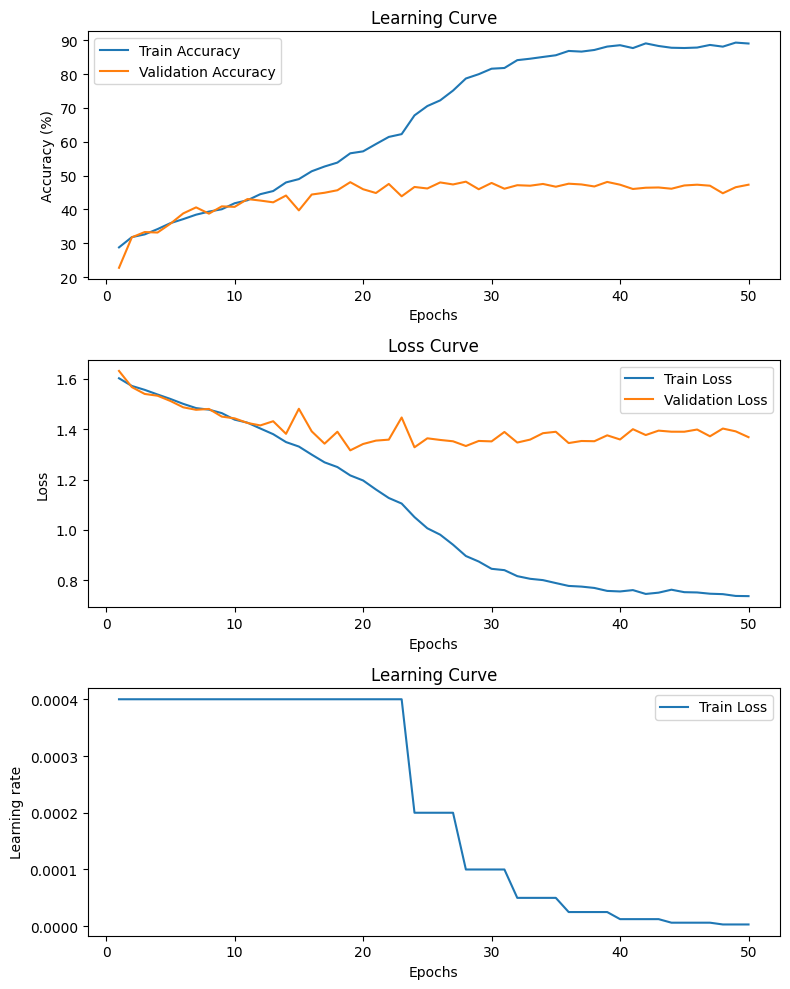

In [28]:
plot_learning_loss(config['epochs'],resnet_34[1])

In [29]:
print(f"Best accuracy {resnet_34[0]['acc']}")

Best accuracy 48.214285714285715


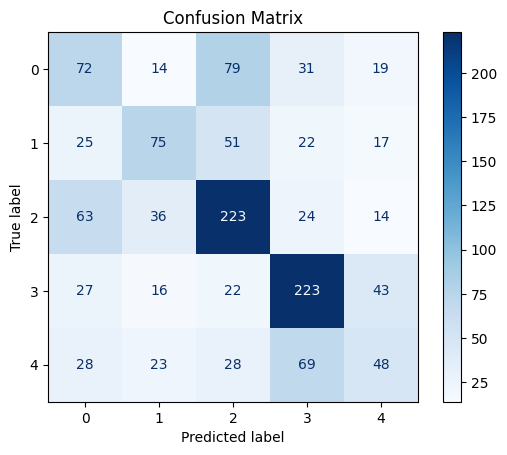

In [30]:
resnet34_confusion_matrix = plot_confusion_matrix(resnet34,checkpoint_dir,resnet_34[0]['epoch'])

***
### <font color="blue">**Observations and Conclusion** </font>
1. **Learning Rate Adjustments and Performance Impact**:
The scheduler reduces the learning rate when the validation loss does not improve, which happens multiple times throughout the training. For example, learning rate reductions at epochs 6, 11, and 16 correlate with improved accuracy shortly afterward. This suggests that the learning rate scheduler effectively helps the model recover and progress when it stalls.
1. **Fluctuating Validation Accuracy and Loss**:
There are notable fluctuations in validation accuracy and loss, which is common in training deep networks but can also suggest that the model might benefit from further fine-tuning of hyperparameters like batch size or more sophisticated data augmentation techniques to stabilize learning.
1. **Use of Gradient Scaling**:
The use of gradient scaling, indicated by the initialization of torch.cuda.amp.GradScaler, helps in dealing with the potential issue of vanishing gradients, especially considering the depth of **ResNet34**. This tool allows for mixed precision training, which maintains training stability and can improve performance by making efficient use of hardware.
1. **Final Accuracy**:
The best reported accuracy is approximately **48%**, achieved towards the end of the training process. This outcome indicates moderate success of the model in classifying the images into one of five categories, but there might be room for improvement.


### <font color="blue">**Suggestions for Improvement** </font>
1. **Data Augmentation**: Implementing more or different data augmentation strategies could help the model generalize better, especially given the signs of overfitting seen as fluctuations in the validation metrics.
1. **Hyperparameter Tuning**: Adjusting the optimizer's parameters, increasing model regularization, or even experimenting with different architectures could yield better results.
***

## <font color="blue">D.3.1.3 ImprovedNet </font>
1. <font color = "blue">**Best Resnet34 Model was at epoch 44:**</font> **Load ckpts_resnet/model_epoch_44.pth** 
2. <font color = "blue">**Key Idea:**</font>  Use the last-layer weight to train the model with K-NN (**K=5**)

Validation Accuracy: 0.7422600619195047


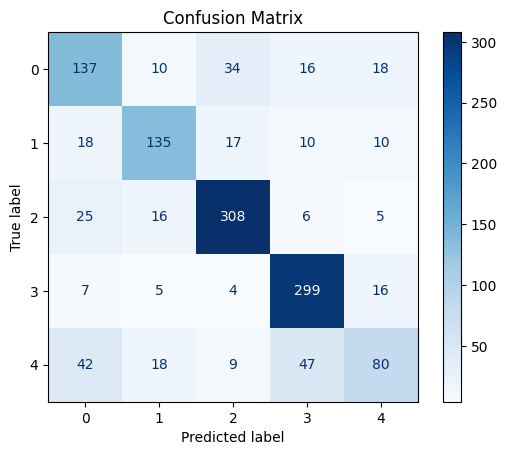

In [73]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Configuration
config = {
    'image_size': (128, 128), 
    'batch_size': 64,
}

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Load the state dictionary and examine the keys
state_dict = torch.load('ckpts_resnet/model_epoch_44.pth')

# Extract only the model-related keys
model_state_dict = state_dict.get("model_state_dict", state_dict)

# Create a new instance of the model
model = torchvision.models.resnet34(weights=None,num_classes=5).to(device)

# Load the state dictionary (ignoring missing/unexpected keys)
model.load_state_dict(model_state_dict, strict=False)  # Use strict=False to ignore key mismatches

# Set to evaluation mode and remove the final layer for feature extraction
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the last layer


# Function to extract features from a dataset
def extract_features(loader, extractor):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, target_labels in loader:
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            outputs = extractor(inputs)  # Get features
            # Flatten to 2D shape
            flattened_features = outputs.view(outputs.size(0), -1)
            features.append(flattened_features.cpu().numpy())
            labels.append(target_labels.cpu().numpy())
    features = np.concatenate(features, axis=0)  # Concatenate all features
    labels = np.concatenate(labels, axis=0)  # Concatenate all labels
    return features, labels

# Extract features from training and validation datasets
train_features, train_labels = extract_features(train_loader, feature_extractor)
valid_features, valid_labels = extract_features(valid_loader, feature_extractor)

# Train a KNN classifier using the extracted features
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(train_features, train_labels)  # Fit the KNN model to the training features

# Evaluate the KNN model on the validation set
valid_predictions = knn.predict(valid_features)

# Calculate accuracy on the validation set
accuracy = accuracy_score(valid_labels, valid_predictions)
print("Validation Accuracy:", accuracy)

# Generate the confusion matrix
conf_matrix = confusion_matrix(valid_labels, valid_predictions)

class_names = [0,1,2,3,4]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix")
plt.show()


In [74]:
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Assuming `knn` is the trained KNN model
knn_model_path = os.path.join(os.getcwd(),'knn_model.pkl')  # .pkl is a common extension for pickle files

# Save the KNN model to a file
with open(knn_model_path, 'wb') as f:
    pickle.dump(knn, f)  # Use 'wb' for writing in binary mode

## <font color="blue">D3.1.4 ShuffleNet V2 </font>

1. <font color = "blue">**Citation:**</font> **(Ningning Ma et al., 2017) ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design** by Tsinghua University 
2. <font color = "blue">**Key Idea:**</font>  A lightweight architecture designed for mobile and edge devices. It uses "channel shuffling" to improve information flow and reduce computation. Additionally, it uses depthwise separable convolutions for efficiency.
3. <font color = "blue">**Documentation:**</font> https://arxiv.org/pdf/1807.11164
4. <font color = "blue">**Result:**</font> Accuracy = 0.42

In [40]:
# Load EfficientNet, selecting the variant that suits your needs
snet = torchvision.models.shufflenet_v2_x0_5(weights=None,num_classes=5).to(device)

***
#### <font color="blue">**Layers with details** </font>
### <font color="green">Initial Layers </font>
1. **Conv2d-1 and BatchNorm2d-2**: The initial convolutional layer and batch normalization prepare the input by extracting initial features and normalizing them, which helps in accelerating the training.
1. **ReLU-3 and MaxPool2d-4**: Activation and pooling further process these features, adding non-linearity and reducing spatial dimensions, respectively, to condense the information
### <font color="green">Channel Shuffling and Depthwise Separable Convolutions: </font>
1. **Depthwise Separable Convolutions (e.g., Conv2d followed by BatchNorm2d and ReLU without changing channel depth)**: These are efficient in terms of computation and parameters as they separate the convolution into depthwise and pointwise operations.

1. **Channel Shuffling**: This occurs implicitly in the architecture through operations that mix channels from group convolutions, ensuring that features processed by different groups can be combined, which increases the representational capabilities of the network.
### <font color="green">Inverted Residual Blocks: </font>
1. **Inverted Residual Structure**: This is a hallmark of efficient designs like ShuffleNet and MobileNet, where the input and output of the block are connected with a residual link, allowing the network to learn modifications to the identity mapping rather than the full output anew, which enhances training speed and efficiency.

***

In [54]:
config = {
    'batch_size': 64, 
    'lr': 4e-4, 
    'epochs': 70, 
    'weight_decay': 0.0005, 
    'momentum': 0.9, 
    'dropout':0.1, 
    'label_smoothing': 0.1,
}

In [55]:
# 3 channels, 128 x 128 dimensions
summary(snet, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 64, 64]             648
       BatchNorm2d-2           [-1, 24, 64, 64]              48
              ReLU-3           [-1, 24, 64, 64]               0
         MaxPool2d-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 16, 16]             216
       BatchNorm2d-6           [-1, 24, 16, 16]              48
            Conv2d-7           [-1, 24, 16, 16]             576
       BatchNorm2d-8           [-1, 24, 16, 16]              48
              ReLU-9           [-1, 24, 16, 16]               0
           Conv2d-10           [-1, 24, 32, 32]             576
      BatchNorm2d-11           [-1, 24, 32, 32]              48
             ReLU-12           [-1, 24, 32, 32]               0
           Conv2d-13           [-1, 24, 16, 16]             216
      BatchNorm2d-14           [-1, 24,

In [56]:

# Directory to save checkpoints
checkpoint_dir = 'ckpts_snet'
os.makedirs(checkpoint_dir, exist_ok=True)


In [57]:
# --------------------------------------------------- #
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(snet.parameters(),
                            lr=config['lr'],
                            momentum=config['momentum'],
                            weight_decay=config['weight_decay'])
# --------------------------------------------------- #

# Defining Scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# --------------------------------------------------- #

# Defining Scaler"

scaler = torch.cuda.amp.GradScaler()

# --------------------------------------------------- #

In [58]:
s_net = CNN_trainer(snet,checkpoint_dir)

  1%|▊                                                     | 1/70 [00:05<06:02,  5.25s/it]


Epoch 1/70
	Train Acc 36.4776%	Train Loss 1.5102	 Learning Rate 0.0004000
Val Acc (Classification) 35.4911%	 Val Loss (Classification) 1.5166
Checkpoint saved at: ckpts_snet/model_epoch_0.pth


  3%|█▌                                                    | 2/70 [00:10<05:55,  5.23s/it]


Epoch 2/70
	Train Acc 35.2816%	Train Loss 1.5224	 Learning Rate 0.0004000
Val Acc (Classification) 34.7470%	 Val Loss (Classification) 1.5214


  4%|██▎                                                   | 3/70 [00:15<05:44,  5.14s/it]


Epoch 3/70
	Train Acc 35.9568%	Train Loss 1.5198	 Learning Rate 0.0004000
Val Acc (Classification) 36.4583%	 Val Loss (Classification) 1.5056
Checkpoint saved at: ckpts_snet/model_epoch_2.pth


  6%|███                                                   | 4/70 [00:20<05:35,  5.08s/it]


Epoch 4/70
	Train Acc 36.2461%	Train Loss 1.5172	 Learning Rate 0.0004000
Val Acc (Classification) 37.2024%	 Val Loss (Classification) 1.5134
Checkpoint saved at: ckpts_snet/model_epoch_3.pth


  7%|███▊                                                  | 5/70 [00:25<05:32,  5.12s/it]


Epoch 5/70
	Train Acc 36.4583%	Train Loss 1.5093	 Learning Rate 0.0004000
Val Acc (Classification) 36.6815%	 Val Loss (Classification) 1.5072


  9%|████▋                                                 | 6/70 [00:30<05:24,  5.07s/it]


Epoch 6/70
	Train Acc 36.9406%	Train Loss 1.5059	 Learning Rate 0.0004000
Val Acc (Classification) 36.6815%	 Val Loss (Classification) 1.5013


 10%|█████▍                                                | 7/70 [00:35<05:18,  5.05s/it]


Epoch 7/70
	Train Acc 37.5579%	Train Loss 1.4962	 Learning Rate 0.0004000
Val Acc (Classification) 38.5417%	 Val Loss (Classification) 1.4761
Checkpoint saved at: ckpts_snet/model_epoch_6.pth


 11%|██████▏                                               | 8/70 [00:40<05:12,  5.03s/it]


Epoch 8/70
	Train Acc 37.5965%	Train Loss 1.4956	 Learning Rate 0.0004000
Val Acc (Classification) 37.9464%	 Val Loss (Classification) 1.4869


 13%|██████▉                                               | 9/70 [00:45<05:07,  5.04s/it]


Epoch 9/70
	Train Acc 37.9051%	Train Loss 1.4933	 Learning Rate 0.0004000
Val Acc (Classification) 37.6488%	 Val Loss (Classification) 1.4922


 14%|███████▌                                             | 10/70 [00:50<05:01,  5.03s/it]


Epoch 10/70
	Train Acc 37.3843%	Train Loss 1.4941	 Learning Rate 0.0004000
Val Acc (Classification) 37.7976%	 Val Loss (Classification) 1.4871


 16%|████████▎                                            | 11/70 [00:55<04:56,  5.03s/it]


Epoch 11/70
	Train Acc 37.9244%	Train Loss 1.4913	 Learning Rate 0.0004000
Val Acc (Classification) 37.7976%	 Val Loss (Classification) 1.4959


 17%|█████████                                            | 12/70 [01:00<04:55,  5.09s/it]


Epoch 12/70
	Train Acc 38.5995%	Train Loss 1.4837	 Learning Rate 0.0002000
Val Acc (Classification) 38.1696%	 Val Loss (Classification) 1.4772


 19%|█████████▊                                           | 13/70 [01:06<04:49,  5.08s/it]


Epoch 13/70
	Train Acc 38.8310%	Train Loss 1.4829	 Learning Rate 0.0002000
Val Acc (Classification) 39.2113%	 Val Loss (Classification) 1.4840
Checkpoint saved at: ckpts_snet/model_epoch_12.pth


 20%|██████████▌                                          | 14/70 [01:11<04:43,  5.06s/it]


Epoch 14/70
	Train Acc 39.4483%	Train Loss 1.4699	 Learning Rate 0.0002000
Val Acc (Classification) 38.7649%	 Val Loss (Classification) 1.4755


 21%|███████████▎                                         | 15/70 [01:16<04:38,  5.06s/it]


Epoch 15/70
	Train Acc 39.7955%	Train Loss 1.4691	 Learning Rate 0.0002000
Val Acc (Classification) 39.8810%	 Val Loss (Classification) 1.4621
Checkpoint saved at: ckpts_snet/model_epoch_14.pth


 23%|████████████                                         | 16/70 [01:21<04:33,  5.07s/it]


Epoch 16/70
	Train Acc 39.6412%	Train Loss 1.4646	 Learning Rate 0.0002000
Val Acc (Classification) 40.4018%	 Val Loss (Classification) 1.4655
Checkpoint saved at: ckpts_snet/model_epoch_15.pth


 24%|████████████▊                                        | 17/70 [01:26<04:27,  5.05s/it]


Epoch 17/70
	Train Acc 39.6798%	Train Loss 1.4612	 Learning Rate 0.0002000
Val Acc (Classification) 40.9970%	 Val Loss (Classification) 1.4472
Checkpoint saved at: ckpts_snet/model_epoch_16.pth


 26%|█████████████▋                                       | 18/70 [01:31<04:21,  5.03s/it]


Epoch 18/70
	Train Acc 40.6057%	Train Loss 1.4557	 Learning Rate 0.0002000
Val Acc (Classification) 40.4018%	 Val Loss (Classification) 1.4534


 27%|██████████████▍                                      | 19/70 [01:36<04:16,  5.03s/it]


Epoch 19/70
	Train Acc 40.3164%	Train Loss 1.4543	 Learning Rate 0.0002000
Val Acc (Classification) 39.2857%	 Val Loss (Classification) 1.4550


 29%|███████████████▏                                     | 20/70 [01:41<04:11,  5.02s/it]


Epoch 20/70
	Train Acc 41.1265%	Train Loss 1.4476	 Learning Rate 0.0002000
Val Acc (Classification) 40.6250%	 Val Loss (Classification) 1.4571


 30%|███████████████▉                                     | 21/70 [01:46<04:05,  5.02s/it]


Epoch 21/70
	Train Acc 41.2230%	Train Loss 1.4426	 Learning Rate 0.0002000
Val Acc (Classification) 40.4762%	 Val Loss (Classification) 1.4585


 31%|████████████████▋                                    | 22/70 [01:51<04:02,  5.05s/it]


Epoch 22/70
	Train Acc 41.5509%	Train Loss 1.4394	 Learning Rate 0.0001000
Val Acc (Classification) 40.3274%	 Val Loss (Classification) 1.4457


 33%|█████████████████▍                                   | 23/70 [01:56<03:56,  5.04s/it]


Epoch 23/70
	Train Acc 41.4931%	Train Loss 1.4379	 Learning Rate 0.0001000
Val Acc (Classification) 40.5506%	 Val Loss (Classification) 1.4472


 34%|██████████████████▏                                  | 24/70 [02:01<03:51,  5.04s/it]


Epoch 24/70
	Train Acc 41.8403%	Train Loss 1.4320	 Learning Rate 0.0001000
Val Acc (Classification) 41.3690%	 Val Loss (Classification) 1.4357
Checkpoint saved at: ckpts_snet/model_epoch_23.pth


 36%|██████████████████▉                                  | 25/70 [02:06<03:46,  5.03s/it]


Epoch 25/70
	Train Acc 42.3804%	Train Loss 1.4239	 Learning Rate 0.0001000
Val Acc (Classification) 40.2530%	 Val Loss (Classification) 1.4448


 37%|███████████████████▋                                 | 26/70 [02:11<03:40,  5.02s/it]


Epoch 26/70
	Train Acc 42.2647%	Train Loss 1.4260	 Learning Rate 0.0001000
Val Acc (Classification) 41.2946%	 Val Loss (Classification) 1.4494


 39%|████████████████████▍                                | 27/70 [02:16<03:35,  5.01s/it]


Epoch 27/70
	Train Acc 43.0941%	Train Loss 1.4194	 Learning Rate 0.0001000
Val Acc (Classification) 41.0714%	 Val Loss (Classification) 1.4375


 40%|█████████████████████▏                               | 28/70 [02:21<03:32,  5.06s/it]


Epoch 28/70
	Train Acc 42.4769%	Train Loss 1.4191	 Learning Rate 0.0001000
Val Acc (Classification) 41.8155%	 Val Loss (Classification) 1.4444
Checkpoint saved at: ckpts_snet/model_epoch_27.pth


 41%|█████████████████████▉                               | 29/70 [02:26<03:26,  5.04s/it]


Epoch 29/70
	Train Acc 43.1520%	Train Loss 1.4153	 Learning Rate 0.0000500
Val Acc (Classification) 41.4435%	 Val Loss (Classification) 1.4403


 43%|██████████████████████▋                              | 30/70 [02:31<03:22,  5.05s/it]


Epoch 30/70
	Train Acc 42.6312%	Train Loss 1.4180	 Learning Rate 0.0000500
Val Acc (Classification) 42.2619%	 Val Loss (Classification) 1.4373
Checkpoint saved at: ckpts_snet/model_epoch_29.pth


 44%|███████████████████████▍                             | 31/70 [02:36<03:16,  5.03s/it]


Epoch 31/70
	Train Acc 43.1134%	Train Loss 1.4111	 Learning Rate 0.0000500
Val Acc (Classification) 41.5923%	 Val Loss (Classification) 1.4376


 46%|████████████████████████▏                            | 32/70 [02:41<03:10,  5.02s/it]


Epoch 32/70
	Train Acc 42.7662%	Train Loss 1.4098	 Learning Rate 0.0000500
Val Acc (Classification) 41.3690%	 Val Loss (Classification) 1.4361


 47%|████████████████████████▉                            | 33/70 [02:47<03:12,  5.20s/it]


Epoch 33/70
	Train Acc 43.3642%	Train Loss 1.4064	 Learning Rate 0.0000250
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4394


 49%|█████████████████████████▋                           | 34/70 [02:52<03:06,  5.19s/it]


Epoch 34/70
	Train Acc 43.9236%	Train Loss 1.4042	 Learning Rate 0.0000250
Val Acc (Classification) 41.2202%	 Val Loss (Classification) 1.4316


 50%|██████████████████████████▌                          | 35/70 [02:57<03:00,  5.16s/it]


Epoch 35/70
	Train Acc 43.4028%	Train Loss 1.4072	 Learning Rate 0.0000250
Val Acc (Classification) 41.5923%	 Val Loss (Classification) 1.4298


 51%|███████████████████████████▎                         | 36/70 [03:02<02:53,  5.10s/it]


Epoch 36/70
	Train Acc 43.8465%	Train Loss 1.4060	 Learning Rate 0.0000250
Val Acc (Classification) 42.1875%	 Val Loss (Classification) 1.4439


 53%|████████████████████████████                         | 37/70 [03:07<02:47,  5.06s/it]


Epoch 37/70
	Train Acc 43.5957%	Train Loss 1.3997	 Learning Rate 0.0000250
Val Acc (Classification) 42.0387%	 Val Loss (Classification) 1.4328


 54%|████████████████████████████▊                        | 38/70 [03:12<02:41,  5.05s/it]


Epoch 38/70
	Train Acc 43.4028%	Train Loss 1.4022	 Learning Rate 0.0000250
Val Acc (Classification) 41.2946%	 Val Loss (Classification) 1.4468


 56%|█████████████████████████████▌                       | 39/70 [03:17<02:36,  5.04s/it]


Epoch 39/70
	Train Acc 43.8850%	Train Loss 1.4001	 Learning Rate 0.0000250
Val Acc (Classification) 40.3274%	 Val Loss (Classification) 1.4477


 57%|██████████████████████████████▎                      | 40/70 [03:22<02:30,  5.02s/it]


Epoch 40/70
	Train Acc 43.6728%	Train Loss 1.4019	 Learning Rate 0.0000125
Val Acc (Classification) 40.6250%	 Val Loss (Classification) 1.4330


 59%|███████████████████████████████                      | 41/70 [03:27<02:25,  5.02s/it]


Epoch 41/70
	Train Acc 43.2292%	Train Loss 1.4008	 Learning Rate 0.0000125
Val Acc (Classification) 41.9643%	 Val Loss (Classification) 1.4431


 60%|███████████████████████████████▊                     | 42/70 [03:32<02:21,  5.04s/it]


Epoch 42/70
	Train Acc 44.1744%	Train Loss 1.3987	 Learning Rate 0.0000125
Val Acc (Classification) 42.2619%	 Val Loss (Classification) 1.4161
Checkpoint saved at: ckpts_snet/model_epoch_41.pth


 61%|████████████████████████████████▌                    | 43/70 [03:37<02:16,  5.05s/it]


Epoch 43/70
	Train Acc 43.5571%	Train Loss 1.3986	 Learning Rate 0.0000125
Val Acc (Classification) 41.1458%	 Val Loss (Classification) 1.4474


 63%|█████████████████████████████████▎                   | 44/70 [03:42<02:12,  5.08s/it]


Epoch 44/70
	Train Acc 44.7338%	Train Loss 1.3997	 Learning Rate 0.0000125
Val Acc (Classification) 40.9226%	 Val Loss (Classification) 1.4389


 64%|██████████████████████████████████                   | 45/70 [03:47<02:06,  5.07s/it]


Epoch 45/70
	Train Acc 44.0972%	Train Loss 1.3987	 Learning Rate 0.0000125
Val Acc (Classification) 41.2202%	 Val Loss (Classification) 1.4451


 66%|██████████████████████████████████▊                  | 46/70 [03:52<02:01,  5.08s/it]


Epoch 46/70
	Train Acc 44.2708%	Train Loss 1.3989	 Learning Rate 0.0000125
Val Acc (Classification) 41.2946%	 Val Loss (Classification) 1.4453


 67%|███████████████████████████████████▌                 | 47/70 [03:57<01:55,  5.04s/it]


Epoch 47/70
	Train Acc 44.4444%	Train Loss 1.3956	 Learning Rate 0.0000063
Val Acc (Classification) 40.4762%	 Val Loss (Classification) 1.4449


 69%|████████████████████████████████████▎                | 48/70 [04:02<01:50,  5.03s/it]


Epoch 48/70
	Train Acc 44.4637%	Train Loss 1.3951	 Learning Rate 0.0000063
Val Acc (Classification) 42.4107%	 Val Loss (Classification) 1.4291
Checkpoint saved at: ckpts_snet/model_epoch_47.pth


 70%|█████████████████████████████████████                | 49/70 [04:07<01:45,  5.02s/it]


Epoch 49/70
	Train Acc 44.4059%	Train Loss 1.3931	 Learning Rate 0.0000063
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4398


 71%|█████████████████████████████████████▊               | 50/70 [04:12<01:40,  5.03s/it]


Epoch 50/70
	Train Acc 44.2515%	Train Loss 1.3946	 Learning Rate 0.0000063
Val Acc (Classification) 41.5179%	 Val Loss (Classification) 1.4434


 73%|██████████████████████████████████████▌              | 51/70 [04:17<01:35,  5.03s/it]


Epoch 51/70
	Train Acc 44.3480%	Train Loss 1.3956	 Learning Rate 0.0000031
Val Acc (Classification) 41.5923%	 Val Loss (Classification) 1.4408


 74%|███████████████████████████████████████▎             | 52/70 [04:22<01:30,  5.02s/it]


Epoch 52/70
	Train Acc 45.0810%	Train Loss 1.3938	 Learning Rate 0.0000031
Val Acc (Classification) 41.7411%	 Val Loss (Classification) 1.4301


 76%|████████████████████████████████████████▏            | 53/70 [04:27<01:25,  5.02s/it]


Epoch 53/70
	Train Acc 44.7724%	Train Loss 1.3882	 Learning Rate 0.0000031
Val Acc (Classification) 42.9315%	 Val Loss (Classification) 1.4365
Checkpoint saved at: ckpts_snet/model_epoch_52.pth


 77%|████████████████████████████████████████▉            | 54/70 [04:33<01:20,  5.03s/it]


Epoch 54/70
	Train Acc 44.5023%	Train Loss 1.3928	 Learning Rate 0.0000031
Val Acc (Classification) 40.7738%	 Val Loss (Classification) 1.4511


 79%|█████████████████████████████████████████▋           | 55/70 [04:38<01:15,  5.02s/it]


Epoch 55/70
	Train Acc 44.5795%	Train Loss 1.3992	 Learning Rate 0.0000016
Val Acc (Classification) 41.1458%	 Val Loss (Classification) 1.4326


 80%|██████████████████████████████████████████▍          | 56/70 [04:43<01:10,  5.02s/it]


Epoch 56/70
	Train Acc 43.8465%	Train Loss 1.3943	 Learning Rate 0.0000016
Val Acc (Classification) 41.7411%	 Val Loss (Classification) 1.4468


 81%|███████████████████████████████████████████▏         | 57/70 [04:48<01:05,  5.05s/it]


Epoch 57/70
	Train Acc 44.1165%	Train Loss 1.3958	 Learning Rate 0.0000016
Val Acc (Classification) 41.8155%	 Val Loss (Classification) 1.4340


 83%|███████████████████████████████████████████▉         | 58/70 [04:53<01:00,  5.02s/it]


Epoch 58/70
	Train Acc 44.2323%	Train Loss 1.3955	 Learning Rate 0.0000016
Val Acc (Classification) 42.2619%	 Val Loss (Classification) 1.4341


 84%|████████████████████████████████████████████▋        | 59/70 [04:58<00:55,  5.03s/it]


Epoch 59/70
	Train Acc 44.3480%	Train Loss 1.3924	 Learning Rate 0.0000008
Val Acc (Classification) 42.3363%	 Val Loss (Classification) 1.4171


 86%|█████████████████████████████████████████████▍       | 60/70 [05:03<00:50,  5.02s/it]


Epoch 60/70
	Train Acc 44.0394%	Train Loss 1.3923	 Learning Rate 0.0000008
Val Acc (Classification) 41.9643%	 Val Loss (Classification) 1.4387


 87%|██████████████████████████████████████████████▏      | 61/70 [05:08<00:45,  5.00s/it]


Epoch 61/70
	Train Acc 43.9622%	Train Loss 1.3946	 Learning Rate 0.0000008
Val Acc (Classification) 40.1042%	 Val Loss (Classification) 1.4478


 89%|██████████████████████████████████████████████▉      | 62/70 [05:13<00:40,  5.01s/it]


Epoch 62/70
	Train Acc 44.5988%	Train Loss 1.3911	 Learning Rate 0.0000008
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4331


 90%|███████████████████████████████████████████████▋     | 63/70 [05:18<00:35,  5.01s/it]


Epoch 63/70
	Train Acc 44.8881%	Train Loss 1.3917	 Learning Rate 0.0000004
Val Acc (Classification) 42.1875%	 Val Loss (Classification) 1.4385


 91%|████████████████████████████████████████████████▍    | 64/70 [05:23<00:29,  4.99s/it]


Epoch 64/70
	Train Acc 44.2901%	Train Loss 1.3960	 Learning Rate 0.0000004
Val Acc (Classification) 42.1875%	 Val Loss (Classification) 1.4322


 93%|█████████████████████████████████████████████████▏   | 65/70 [05:28<00:25,  5.00s/it]


Epoch 65/70
	Train Acc 45.2739%	Train Loss 1.3920	 Learning Rate 0.0000004
Val Acc (Classification) 42.3363%	 Val Loss (Classification) 1.4349


 94%|█████████████████████████████████████████████████▉   | 66/70 [05:33<00:20,  5.04s/it]


Epoch 66/70
	Train Acc 44.3673%	Train Loss 1.3956	 Learning Rate 0.0000004
Val Acc (Classification) 41.2946%	 Val Loss (Classification) 1.4416


 96%|██████████████████████████████████████████████████▋  | 67/70 [05:38<00:15,  5.08s/it]


Epoch 67/70
	Train Acc 44.8495%	Train Loss 1.3890	 Learning Rate 0.0000002
Val Acc (Classification) 41.9643%	 Val Loss (Classification) 1.4228


 97%|███████████████████████████████████████████████████▍ | 68/70 [05:43<00:10,  5.07s/it]


Epoch 68/70
	Train Acc 44.4637%	Train Loss 1.3888	 Learning Rate 0.0000002
Val Acc (Classification) 41.4435%	 Val Loss (Classification) 1.4412


 99%|████████████████████████████████████████████████████▏| 69/70 [05:48<00:05,  5.06s/it]


Epoch 69/70
	Train Acc 43.7114%	Train Loss 1.3935	 Learning Rate 0.0000002
Val Acc (Classification) 41.3690%	 Val Loss (Classification) 1.4420


100%|█████████████████████████████████████████████████████| 70/70 [05:53<00:00,  5.05s/it]


Epoch 70/70
	Train Acc 44.4059%	Train Loss 1.3908	 Learning Rate 0.0000002
Val Acc (Classification) 42.1875%	 Val Loss (Classification) 1.4362


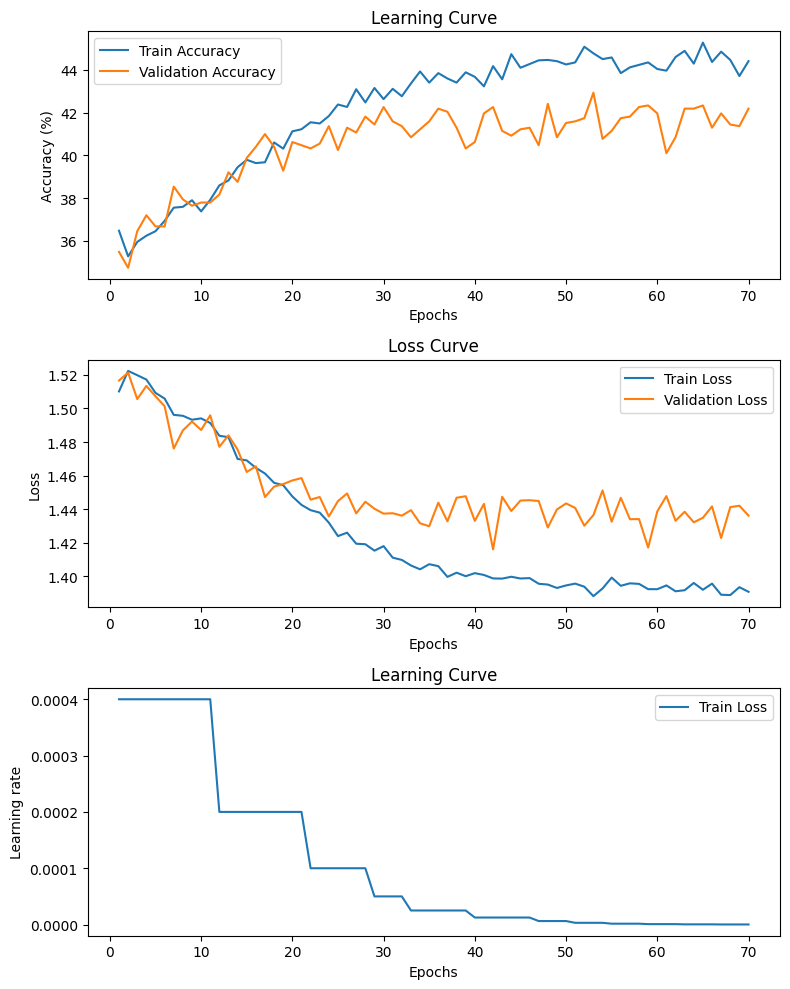

In [59]:
plot_learning_loss(config['epochs'],s_net[1])

In [60]:
print(f"Best accuracy {s_net[0]['acc']}")

Best accuracy 42.93154761904762


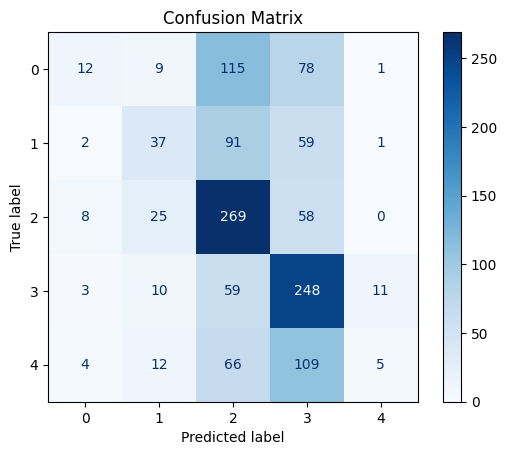

In [61]:
shufflenet_confusion_matrix = plot_confusion_matrix(snet,checkpoint_dir,s_net[0]['epoch'])

***
### <font color="blue">**Observations and Conclusion** </font>
1. **Efficiency** : The network architecture, by using fewer parameters (only **346,917** compared to millions in traditional architectures like ResNet), makes it ideal for deployment on devices with limited computational power and memory.
1. **Training Dynamics**:
The initial accuracy starts low but improves as the training progresses, indicative of the model gradually learning from the features.
The use of a learning rate scheduler and gradient scaling suggests attempts to handle deeper and potentially unstable training phases efficiently, which is crucial given the lower capacity of the network.
1. **Performance**:
The best accuracy achieved is around **42%**, which is quite reasonable given the constraints of the model in terms of size and computational requirements. However, it lags behind more computationally heavy models, underscoring the trade-off between efficiency and accuracy.
1. **Stability Issues**:
Fluctuations in validation accuracy and loss suggest some overfitting or instability in learning, which might be addressed by tweaking hyperparameters, enhancing regularization, or incorporating more robust data augmentation.
1. **Learning Rate Adjustments**:
The scheduler reduces the learning rate when the loss plateaus, which happens several times during training, suggesting that the network benefits from finer adjustments in the learning rate as training progresses.

***
## <font color="blue">D3.1.4 MobileNet V2</font>

1. <font color = "blue">**Citation:**</font> **(Mark Sandler et al., 2017) MobileNetV2: Inverted Residuals and Linear Bottlenecks by Google Research** 
2. <font color = "blue">**Key Idea:**</font>   Uses depthwise separable convolutions to reduce computation and model size, making it suitable for mobile devices. It has hyperparameters (like width multiplier and resolution multiplier) to control the trade-offs between accuracy, latency, and size.
3. <font color = "blue">**Documentation:**</font> https://arxiv.org/pdf/1801.04381
4. <font color = "blue">**Result:**</font> Accuracy = 0.47

In [178]:
m_net_v2 = torchvision.models.mobilenet_v2(weights=None,num_classes=5).to(device)
summary(m_net_v2,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### <font color="blue">**Layers with Details**</font>

<font color="green">**Initial Layers**</font>

1. **Conv2d-1 and BatchNorm2d-2**: The initial convolutional layer and batch normalization prepare the input by extracting initial features and normalizing them, which helps in accelerating the training.

1. **ReLU6-3 and MaxPool2d-4** : Activation and pooling further process these features, adding non-linearity and reducing spatial dimensions, respectively, to condense the information.

<font color="green">**Channel Shuffling and Depthwise Separable Convolutions**</font>

1. **Depthwise Separable Convolutions (e.g., Conv2d-4, BatchNorm2d-5, ReLU6-6 followed by Conv2d-7)**: These are efficient in terms of computation and parameters as they separate the convolution into depthwise and pointwise operations. They manage to perform filtering and combining features separately, which reduces the computational cost.

<font color="green">**Inverted Residual Blocks**</font>

1. **Inverted Residual Structures (e.g., InvertedResidual-9)** : This architectural element is a hallmark of MobileNet V2, where the input and output of the block are connected with a residual link. This setup allows the network to learn modifications to the identity mapping rather than the full output anew, which enhances training speed and efficiency.

In [179]:
checkpoint_dir = 'ckpts_mnetv2'
os.makedirs(checkpoint_dir, exist_ok=True)

In [180]:
# --------------------------------------------------- #
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(m_net_v2.parameters(),
                            lr=config['lr'],
                            momentum=config['momentum'],
                            weight_decay=config['weight_decay'])

# --------------------------------------------------- #

# Defining Scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# --------------------------------------------------- #

# Defining Scaler

scaler = torch.cuda.amp.GradScaler()

# --------------------------------------------------- #

In [181]:
mobile_net_v2 = CNN_trainer(m_net_v2,checkpoint_dir)


                                                                                          
  2%|█                                                     | 1/50 [00:05<04:36,  5.65s/it]


Epoch 1/50
	Train Acc 26.3889%	Train Loss 1.5938	 Learning Rate 0.0004000
Val Acc (Classification) 20.6845%	 Val Loss (Classification) 1.6051
Checkpoint saved at: ckpts_mnetv2/model_epoch_0.pth


                                                                                          
  4%|██▏                                                   | 2/50 [00:10<04:22,  5.47s/it]


Epoch 2/50
	Train Acc 27.9514%	Train Loss 1.5853	 Learning Rate 0.0004000
Val Acc (Classification) 28.1250%	 Val Loss (Classification) 1.5994
Checkpoint saved at: ckpts_mnetv2/model_epoch_1.pth


                                                                                          
  6%|███▏                                                  | 3/50 [00:16<04:09,  5.31s/it]


Epoch 3/50
	Train Acc 30.2083%	Train Loss 1.5794	 Learning Rate 0.0004000
Val Acc (Classification) 27.8274%	 Val Loss (Classification) 1.5825


                                                                                          
  8%|████▎                                                 | 4/50 [00:21<04:02,  5.27s/it]


Epoch 4/50
	Train Acc 30.6713%	Train Loss 1.5783	 Learning Rate 0.0004000
Val Acc (Classification) 28.4226%	 Val Loss (Classification) 1.5921
Checkpoint saved at: ckpts_mnetv2/model_epoch_3.pth


                                                                                          
 10%|█████▍                                                | 5/50 [00:26<03:59,  5.32s/it]


Epoch 5/50
	Train Acc 29.6875%	Train Loss 1.5749	 Learning Rate 0.0004000
Val Acc (Classification) 28.2738%	 Val Loss (Classification) 1.5976


                                                                                          
 12%|██████▍                                               | 6/50 [00:31<03:52,  5.29s/it]


Epoch 6/50
	Train Acc 29.9190%	Train Loss 1.5712	 Learning Rate 0.0004000
Val Acc (Classification) 28.6458%	 Val Loss (Classification) 1.5956
Checkpoint saved at: ckpts_mnetv2/model_epoch_5.pth


                                                                                          
 14%|███████▌                                              | 7/50 [00:37<03:46,  5.26s/it]


Epoch 7/50
	Train Acc 32.3881%	Train Loss 1.5580	 Learning Rate 0.0004000
Val Acc (Classification) 27.5298%	 Val Loss (Classification) 1.5904


                                                                                          
 16%|████████▋                                             | 8/50 [00:42<03:40,  5.25s/it]


Epoch 8/50
	Train Acc 34.1435%	Train Loss 1.5417	 Learning Rate 0.0002000
Val Acc (Classification) 33.7054%	 Val Loss (Classification) 1.5466
Checkpoint saved at: ckpts_mnetv2/model_epoch_7.pth


                                                                                          
 18%|█████████▋                                            | 9/50 [00:47<03:32,  5.19s/it]


Epoch 9/50
	Train Acc 35.4552%	Train Loss 1.5285	 Learning Rate 0.0002000
Val Acc (Classification) 30.2827%	 Val Loss (Classification) 1.5738


                                                                                          
 20%|██████████▌                                          | 10/50 [00:52<03:26,  5.17s/it]


Epoch 10/50
	Train Acc 35.8218%	Train Loss 1.5190	 Learning Rate 0.0002000
Val Acc (Classification) 32.8869%	 Val Loss (Classification) 1.5411


                                                                                          
 22%|███████████▋                                         | 11/50 [00:57<03:22,  5.20s/it]


Epoch 11/50
	Train Acc 36.5548%	Train Loss 1.5156	 Learning Rate 0.0002000
Val Acc (Classification) 31.4732%	 Val Loss (Classification) 1.5516


                                                                                          
 24%|████████████▋                                        | 12/50 [01:03<03:18,  5.22s/it]


Epoch 12/50
	Train Acc 36.5741%	Train Loss 1.5089	 Learning Rate 0.0002000
Val Acc (Classification) 33.7798%	 Val Loss (Classification) 1.5312
Checkpoint saved at: ckpts_mnetv2/model_epoch_11.pth


                                                                                          
 26%|█████████████▊                                       | 13/50 [01:08<03:13,  5.23s/it]


Epoch 13/50
	Train Acc 36.5548%	Train Loss 1.5105	 Learning Rate 0.0002000
Val Acc (Classification) 34.7470%	 Val Loss (Classification) 1.5294
Checkpoint saved at: ckpts_mnetv2/model_epoch_12.pth


                                                                                          
 28%|██████████████▊                                      | 14/50 [01:13<03:09,  5.27s/it]


Epoch 14/50
	Train Acc 36.8827%	Train Loss 1.5007	 Learning Rate 0.0002000
Val Acc (Classification) 33.1101%	 Val Loss (Classification) 1.5381


                                                                                          
 30%|███████████████▉                                     | 15/50 [01:18<03:03,  5.25s/it]


Epoch 15/50
	Train Acc 37.5000%	Train Loss 1.5007	 Learning Rate 0.0002000
Val Acc (Classification) 34.0774%	 Val Loss (Classification) 1.5281


                                                                                          
 32%|████████████████▉                                    | 16/50 [01:24<02:58,  5.24s/it]


Epoch 16/50
	Train Acc 37.3650%	Train Loss 1.4953	 Learning Rate 0.0002000
Val Acc (Classification) 34.7470%	 Val Loss (Classification) 1.5260
Checkpoint saved at: ckpts_mnetv2/model_epoch_15.pth


                                                                                          
 34%|██████████████████                                   | 17/50 [01:29<02:52,  5.21s/it]


Epoch 17/50
	Train Acc 37.7315%	Train Loss 1.4931	 Learning Rate 0.0002000
Val Acc (Classification) 33.5565%	 Val Loss (Classification) 1.5396


                                                                                          
 36%|███████████████████                                  | 18/50 [01:34<02:45,  5.17s/it]


Epoch 18/50
	Train Acc 37.4228%	Train Loss 1.4941	 Learning Rate 0.0002000
Val Acc (Classification) 34.0774%	 Val Loss (Classification) 1.5242


                                                                                          
 38%|████████████████████▏                                | 19/50 [01:39<02:40,  5.17s/it]


Epoch 19/50
	Train Acc 38.2909%	Train Loss 1.4913	 Learning Rate 0.0002000
Val Acc (Classification) 34.9702%	 Val Loss (Classification) 1.5218
Checkpoint saved at: ckpts_mnetv2/model_epoch_18.pth


                                                                                          
 40%|█████████████████████▏                               | 20/50 [01:44<02:35,  5.18s/it]


Epoch 20/50
	Train Acc 38.1173%	Train Loss 1.4817	 Learning Rate 0.0002000
Val Acc (Classification) 31.6220%	 Val Loss (Classification) 1.5626


                                                                                          
 42%|██████████████████████▎                              | 21/50 [01:49<02:29,  5.16s/it]


Epoch 21/50
	Train Acc 38.7346%	Train Loss 1.4801	 Learning Rate 0.0002000
Val Acc (Classification) 36.0863%	 Val Loss (Classification) 1.5068
Checkpoint saved at: ckpts_mnetv2/model_epoch_20.pth


                                                                                          
 44%|███████████████████████▎                             | 22/50 [01:54<02:23,  5.14s/it]


Epoch 22/50
	Train Acc 38.5031%	Train Loss 1.4814	 Learning Rate 0.0002000
Val Acc (Classification) 36.2351%	 Val Loss (Classification) 1.5034
Checkpoint saved at: ckpts_mnetv2/model_epoch_21.pth


                                                                                          
 46%|████████████████████████▍                            | 23/50 [02:00<02:18,  5.12s/it]


Epoch 23/50
	Train Acc 39.4097%	Train Loss 1.4689	 Learning Rate 0.0002000
Val Acc (Classification) 35.4167%	 Val Loss (Classification) 1.5088


                                                                                          
 48%|█████████████████████████▍                           | 24/50 [02:05<02:12,  5.11s/it]


Epoch 24/50
	Train Acc 39.6412%	Train Loss 1.4618	 Learning Rate 0.0002000
Val Acc (Classification) 35.5655%	 Val Loss (Classification) 1.5094


                                                                                          
 50%|██████████████████████████▌                          | 25/50 [02:10<02:08,  5.12s/it]


Epoch 25/50
	Train Acc 39.8341%	Train Loss 1.4573	 Learning Rate 0.0002000
Val Acc (Classification) 36.4583%	 Val Loss (Classification) 1.5025
Checkpoint saved at: ckpts_mnetv2/model_epoch_24.pth


                                                                                          
 52%|███████████████████████████▌                         | 26/50 [02:15<02:02,  5.12s/it]


Epoch 26/50
	Train Acc 40.1042%	Train Loss 1.4586	 Learning Rate 0.0002000
Val Acc (Classification) 36.0119%	 Val Loss (Classification) 1.5075


                                                                                          
 54%|████████████████████████████▌                        | 27/50 [02:20<01:58,  5.14s/it]


Epoch 27/50
	Train Acc 40.6829%	Train Loss 1.4478	 Learning Rate 0.0002000
Val Acc (Classification) 37.4256%	 Val Loss (Classification) 1.5065
Checkpoint saved at: ckpts_mnetv2/model_epoch_26.pth


                                                                                          
 56%|█████████████████████████████▋                       | 28/50 [02:25<01:52,  5.14s/it]


Epoch 28/50
	Train Acc 40.9915%	Train Loss 1.4436	 Learning Rate 0.0002000
Val Acc (Classification) 37.6488%	 Val Loss (Classification) 1.4809
Checkpoint saved at: ckpts_mnetv2/model_epoch_27.pth


                                                                                          
 58%|██████████████████████████████▋                      | 29/50 [02:30<01:48,  5.14s/it]


Epoch 29/50
	Train Acc 41.9174%	Train Loss 1.4328	 Learning Rate 0.0002000
Val Acc (Classification) 36.2351%	 Val Loss (Classification) 1.4962


                                                                                          
 60%|███████████████████████████████▊                     | 30/50 [02:35<01:42,  5.13s/it]


Epoch 30/50
	Train Acc 41.2616%	Train Loss 1.4292	 Learning Rate 0.0002000
Val Acc (Classification) 37.2024%	 Val Loss (Classification) 1.4906


                                                                                          
 62%|████████████████████████████████▊                    | 31/50 [02:41<01:37,  5.13s/it]


Epoch 31/50
	Train Acc 41.6281%	Train Loss 1.4250	 Learning Rate 0.0002000
Val Acc (Classification) 38.0208%	 Val Loss (Classification) 1.4724
Checkpoint saved at: ckpts_mnetv2/model_epoch_30.pth


                                                                                          
 64%|█████████████████████████████████▉                   | 32/50 [02:46<01:32,  5.15s/it]


Epoch 32/50
	Train Acc 42.1682%	Train Loss 1.4254	 Learning Rate 0.0002000
Val Acc (Classification) 39.5089%	 Val Loss (Classification) 1.4660
Checkpoint saved at: ckpts_mnetv2/model_epoch_31.pth


                                                                                          
 66%|██████████████████████████████████▉                  | 33/50 [02:51<01:27,  5.14s/it]


Epoch 33/50
	Train Acc 41.6860%	Train Loss 1.4247	 Learning Rate 0.0002000
Val Acc (Classification) 38.1696%	 Val Loss (Classification) 1.4939


                                                                                          
 68%|████████████████████████████████████                 | 34/50 [02:56<01:22,  5.16s/it]


Epoch 34/50
	Train Acc 42.0139%	Train Loss 1.4139	 Learning Rate 0.0002000
Val Acc (Classification) 39.2857%	 Val Loss (Classification) 1.4745


                                                                                          
 70%|█████████████████████████████████████                | 35/50 [03:01<01:17,  5.15s/it]


Epoch 35/50
	Train Acc 43.4028%	Train Loss 1.3983	 Learning Rate 0.0002000
Val Acc (Classification) 35.0446%	 Val Loss (Classification) 1.5117


                                                                                          
 72%|██████████████████████████████████████▏              | 36/50 [03:06<01:11,  5.14s/it]


Epoch 36/50
	Train Acc 44.5216%	Train Loss 1.3965	 Learning Rate 0.0002000
Val Acc (Classification) 38.0208%	 Val Loss (Classification) 1.4659


                                                                                          
 74%|███████████████████████████████████████▏             | 37/50 [03:12<01:07,  5.19s/it]


Epoch 37/50
	Train Acc 43.7693%	Train Loss 1.3873	 Learning Rate 0.0001000
Val Acc (Classification) 39.2113%	 Val Loss (Classification) 1.4632


                                                                                          
 76%|████████████████████████████████████████▎            | 38/50 [03:17<01:02,  5.23s/it]


Epoch 38/50
	Train Acc 44.7917%	Train Loss 1.3792	 Learning Rate 0.0001000
Val Acc (Classification) 39.6577%	 Val Loss (Classification) 1.4571
Checkpoint saved at: ckpts_mnetv2/model_epoch_37.pth


                                                                                          
 78%|█████████████████████████████████████████▎           | 39/50 [03:22<00:57,  5.20s/it]


Epoch 39/50
	Train Acc 44.6373%	Train Loss 1.3704	 Learning Rate 0.0001000
Val Acc (Classification) 38.6905%	 Val Loss (Classification) 1.4706


                                                                                          
 80%|██████████████████████████████████████████▍          | 40/50 [03:27<00:51,  5.20s/it]


Epoch 40/50
	Train Acc 45.1003%	Train Loss 1.3704	 Learning Rate 0.0001000
Val Acc (Classification) 38.4673%	 Val Loss (Classification) 1.4479


                                                                                          
 82%|███████████████████████████████████████████▍         | 41/50 [03:32<00:46,  5.19s/it]


Epoch 41/50
	Train Acc 46.0841%	Train Loss 1.3664	 Learning Rate 0.0001000
Val Acc (Classification) 39.2113%	 Val Loss (Classification) 1.4571


                                                                                          
 84%|████████████████████████████████████████████▌        | 42/50 [03:38<00:41,  5.22s/it]


Epoch 42/50
	Train Acc 46.0455%	Train Loss 1.3477	 Learning Rate 0.0001000
Val Acc (Classification) 40.6994%	 Val Loss (Classification) 1.4479
Checkpoint saved at: ckpts_mnetv2/model_epoch_41.pth


                                                                                          
 86%|█████████████████████████████████████████████▌       | 43/50 [03:43<00:36,  5.18s/it]


Epoch 43/50
	Train Acc 47.8009%	Train Loss 1.3387	 Learning Rate 0.0001000
Val Acc (Classification) 39.0625%	 Val Loss (Classification) 1.4639


                                                                                          
 88%|██████████████████████████████████████████████▋      | 44/50 [03:48<00:31,  5.20s/it]


Epoch 44/50
	Train Acc 47.1644%	Train Loss 1.3345	 Learning Rate 0.0001000
Val Acc (Classification) 38.9137%	 Val Loss (Classification) 1.4591


                                                                                          
 90%|███████████████████████████████████████████████▋     | 45/50 [03:53<00:25,  5.19s/it]


Epoch 45/50
	Train Acc 47.4730%	Train Loss 1.3324	 Learning Rate 0.0000500
Val Acc (Classification) 40.4762%	 Val Loss (Classification) 1.4439


                                                                                          
 92%|████████████████████████████████████████████████▊    | 46/50 [03:58<00:20,  5.17s/it]


Epoch 46/50
	Train Acc 47.5694%	Train Loss 1.3263	 Learning Rate 0.0000500
Val Acc (Classification) 39.2113%	 Val Loss (Classification) 1.4472


                                                                                          
 94%|█████████████████████████████████████████████████▊   | 47/50 [04:04<00:15,  5.17s/it]


Epoch 47/50
	Train Acc 48.1096%	Train Loss 1.3142	 Learning Rate 0.0000500
Val Acc (Classification) 38.8393%	 Val Loss (Classification) 1.4450


                                                                                          
 96%|██████████████████████████████████████████████████▉  | 48/50 [04:09<00:10,  5.23s/it]


Epoch 48/50
	Train Acc 48.0903%	Train Loss 1.3157	 Learning Rate 0.0000500
Val Acc (Classification) 39.6577%	 Val Loss (Classification) 1.4501


                                                                                          
 98%|███████████████████████████████████████████████████▉ | 49/50 [04:14<00:05,  5.23s/it]


Epoch 49/50
	Train Acc 48.7461%	Train Loss 1.3073	 Learning Rate 0.0000500
Val Acc (Classification) 39.0625%	 Val Loss (Classification) 1.4450


                                                                                          
100%|█████████████████████████████████████████████████████| 50/50 [04:19<00:00,  5.20s/it]


Epoch 50/50
	Train Acc 49.3827%	Train Loss 1.3024	 Learning Rate 0.0000250
Val Acc (Classification) 40.1042%	 Val Loss (Classification) 1.4469


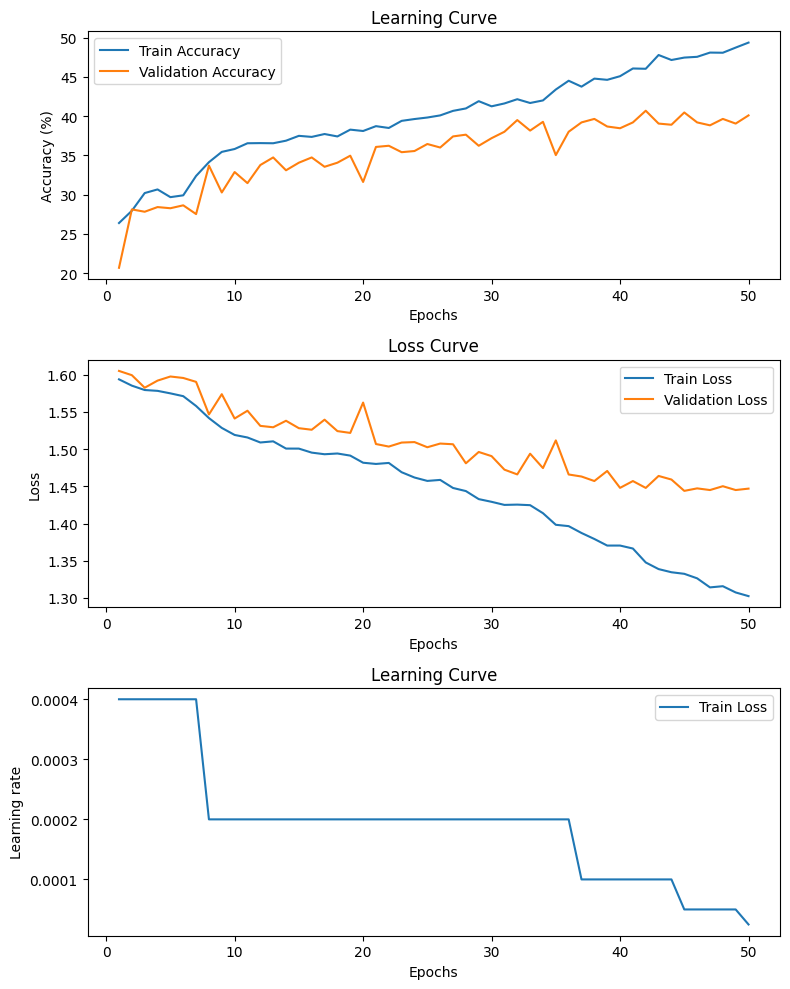

In [182]:
plot_learning_loss(config['epochs'],mobile_net_v2[1])

In [183]:
print(f"Best accuracy {mobile_net_v2[0]['acc']}")

Best accuracy 40.69940476190476


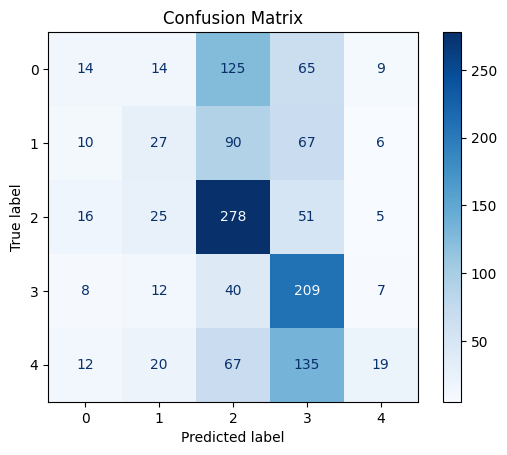

In [184]:
mobilenet_confusion_matrix = plot_confusion_matrix(m_net_v2,checkpoint_dir,mobile_net_v2[0]['epoch'])

<font color="blue">**Observations and Conclusion**</font>

1. **Efficiency** : The network architecture uses a significantly reduced number of parameters **(2,230,277)**, which is efficient for mobile and embedded devices with limited computational resources.

1. **Training Dynamics** :
The training starts with low accuracy, which gradually improves, indicating effective learning over time.
The use of a learning rate scheduler and gradient scaling aids in managing training phases that might be unstable due to the network's capacity.

1. **Performance** :
The maximum accuracy reached is around **47%**, which is decent given the model's constraints on size and computational demands. The performance illustrates a balance between efficiency and accuracy.

1. **Stability Issues** :
Variability in validation accuracy and loss across epochs suggests potential overfitting or instability in learning. This could be managed by adjusting hyperparameters, enhancing regularization strategies, or improving the training data's diversity through augmented techniques.

## <font color="blue"> D3.1.5 ConvNeXt </font>

1. <font color = "blue">**Citation:**</font> **(Zhuang Liu et al., 2020) A ConvNet for the 2020s by Facebook AI Research** 
2. <font color = "blue">**Key Idea:**</font>   Using ResNet50 as a baseline, A convolutional architecture designed with concepts borrowed from Vision Transformers (ViT), like more uniform layer scaling, normalized activations, and a structured approach to model complexity. It aims to be competitive with transformer-based architectures while retaining the benefits of convolutions.
3. <font color = "blue">**Documentation:**</font> https://arxiv.org/pdf/2201.03545
4. <font color = "blue">**Code:**</font>  https://github.com/facebookresearch/ConvNeXt
5. <font color = "blue">**Result:**</font> Accuracy: **72.3** (the best one we have so far)

In [48]:
config = {
    'batch_size': 64, 
    'lr': 1e-4,
    'epochs': 50, 
    'weight_decay': 0.0005,
    'momentum': 0.9,
    'dropout': 0.01, 
    'label_smoothing': 0.1,
}

In [49]:
convnext_small = torchvision.models.convnext_small(weights=None,num_classes=5).to(device)
summary(convnext_small,(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           4,704
       LayerNorm2d-2           [-1, 96, 32, 32]             192
            Conv2d-3           [-1, 96, 32, 32]           4,800
           Permute-4           [-1, 32, 32, 96]               0
         LayerNorm-5           [-1, 32, 32, 96]             192
            Linear-6          [-1, 32, 32, 384]          37,248
              GELU-7          [-1, 32, 32, 384]               0
            Linear-8           [-1, 32, 32, 96]          36,960
           Permute-9           [-1, 96, 32, 32]               0
  StochasticDepth-10           [-1, 96, 32, 32]               0
          CNBlock-11           [-1, 96, 32, 32]               0
           Conv2d-12           [-1, 96, 32, 32]           4,800
          Permute-13           [-1, 32, 32, 96]               0
        LayerNorm-14           [-1, 32,

<font color="blue">**Layers with Details for ConvNeXt**</font>

<font color="green">**Initial Layers** </font>

1. **Conv2d-1 and LayerNorm2d-2** : Begins with a convolution to extract low-level features, immediately followed by layer normalization which normalizes across the spatial dimensions of the activations, stabilizing and speeding up the training.

<font color="green">**Convolution and Transformation Blocks**</font>

1. **Conv2d-3, Permute-4, LayerNorm-5, and Linear Layers (6, 8)**: Each CNBlock begins with a convolution layer, then permutes and normalizes the feature maps to prepare for transformation by linear layers. This structure mimics transformer behavior in a convolutional framework.

1. **GELU Activation**: Utilizes Gaussian Error Linear Units (GELU) for introducing non-linearity, beneficial for modeling complex patterns effectively.

<font color="green">**Permutation and Stochastic Depth** </font>

1. **Permutation and StochasticDepth (e.g., Permute-9, StochasticDepth-10)**: Permuting the dimensions to align features for the linear transformation. Stochastic Depth randomly drops layers during training to promote network resilience and reduce overfitting.

<font color="green">**Scaling to Higher Dimensions**</font>

1. **Increasing Channels (e.g., Conv2d-31, Linear-35)**: The network increases the number of channels as it progresses deeper, allowing it to learn more complex features at each stage.

1. **Layer Normalization and Linear Transformation at Higher Dimensions**: Normalization continues at higher dimensions to maintain training stability, followed by more expansive linear transformations, leveraging increased computation for deeper feature interactions.

In [63]:
checkpoint_dir = 'ckpts_convnext'
os.makedirs(checkpoint_dir, exist_ok=True)

# --------------------------------------------------- #
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(convnext_small.parameters(),
                            weight_decay=config['weight_decay'])

# --------------------------------------------------- #

# Defining Scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# --------------------------------------------------- #

# Defining Scaler

scaler = torch.cuda.amp.GradScaler()

# --------------------------------------------------- #

In [64]:
convnext = CNN_trainer(convnext_small,checkpoint_dir)


Epoch 1/70
	Train Acc 30.6327%	Train Loss 1.6049	 Learning Rate 0.0010000
Val Acc (Classification) 34.8958%	 Val Loss (Classification) 1.5464


  1%|▊                                                     | 1/70 [00:08<09:57,  8.65s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_0.pth



Epoch 2/70
	Train Acc 33.3526%	Train Loss 1.5631	 Learning Rate 0.0010000
Val Acc (Classification) 34.9702%	 Val Loss (Classification) 1.5338


  3%|█▌                                                    | 2/70 [00:17<09:59,  8.81s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_1.pth



Epoch 3/70
	Train Acc 33.6034%	Train Loss 1.5493	 Learning Rate 0.0010000
Val Acc (Classification) 36.5327%	 Val Loss (Classification) 1.5213


  4%|██▎                                                   | 3/70 [00:26<09:38,  8.64s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_2.pth


  6%|███                                                   | 4/70 [00:33<09:12,  8.37s/it]


Epoch 4/70
	Train Acc 35.5324%	Train Loss 1.5390	 Learning Rate 0.0010000
Val Acc (Classification) 28.5714%	 Val Loss (Classification) 1.5304



Epoch 5/70
	Train Acc 35.0502%	Train Loss 1.5281	 Learning Rate 0.0010000
Val Acc (Classification) 37.3512%	 Val Loss (Classification) 1.5131


  7%|███▊                                                  | 5/70 [00:42<09:06,  8.41s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_4.pth


  9%|████▋                                                 | 6/70 [00:50<08:39,  8.12s/it]


Epoch 6/70
	Train Acc 36.3812%	Train Loss 1.5205	 Learning Rate 0.0010000
Val Acc (Classification) 37.0536%	 Val Loss (Classification) 1.4938



Epoch 7/70
	Train Acc 36.1883%	Train Loss 1.5174	 Learning Rate 0.0010000
Val Acc (Classification) 37.8720%	 Val Loss (Classification) 1.4911


 10%|█████▍                                                | 7/70 [00:57<08:28,  8.07s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_6.pth



Epoch 8/70
	Train Acc 36.2461%	Train Loss 1.5172	 Learning Rate 0.0010000
Val Acc (Classification) 38.0952%	 Val Loss (Classification) 1.4876


 11%|██████▏                                               | 8/70 [01:06<08:22,  8.10s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_7.pth



Epoch 9/70
	Train Acc 36.4776%	Train Loss 1.5150	 Learning Rate 0.0010000
Val Acc (Classification) 38.3185%	 Val Loss (Classification) 1.4966


 13%|██████▉                                               | 9/70 [01:14<08:13,  8.10s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_8.pth


 14%|███████▌                                             | 10/70 [01:21<07:49,  7.82s/it]


Epoch 10/70
	Train Acc 36.4776%	Train Loss 1.5136	 Learning Rate 0.0010000
Val Acc (Classification) 37.3512%	 Val Loss (Classification) 1.4846


 16%|████████▎                                            | 11/70 [01:29<07:44,  7.88s/it]


Epoch 11/70
	Train Acc 37.8472%	Train Loss 1.5006	 Learning Rate 0.0010000
Val Acc (Classification) 36.6071%	 Val Loss (Classification) 1.4976


 17%|█████████                                            | 12/70 [01:37<07:37,  7.89s/it]


Epoch 12/70
	Train Acc 37.1721%	Train Loss 1.5007	 Learning Rate 0.0010000
Val Acc (Classification) 35.7887%	 Val Loss (Classification) 1.5279


 19%|█████████▊                                           | 13/70 [01:44<07:12,  7.59s/it]


Epoch 13/70
	Train Acc 37.0756%	Train Loss 1.5028	 Learning Rate 0.0010000
Val Acc (Classification) 36.9792%	 Val Loss (Classification) 1.5025


 20%|██████████▌                                          | 14/70 [01:51<06:53,  7.38s/it]


Epoch 14/70
	Train Acc 37.4421%	Train Loss 1.5002	 Learning Rate 0.0010000
Val Acc (Classification) 37.0536%	 Val Loss (Classification) 1.4993


 21%|███████████▎                                         | 15/70 [01:58<06:42,  7.32s/it]


Epoch 15/70
	Train Acc 38.0015%	Train Loss 1.4849	 Learning Rate 0.0005000
Val Acc (Classification) 37.5000%	 Val Loss (Classification) 1.4731


 23%|████████████                                         | 16/70 [02:05<06:39,  7.39s/it]


Epoch 16/70
	Train Acc 38.4645%	Train Loss 1.4856	 Learning Rate 0.0005000
Val Acc (Classification) 38.0208%	 Val Loss (Classification) 1.4841



Epoch 17/70
	Train Acc 38.3873%	Train Loss 1.4806	 Learning Rate 0.0005000
Val Acc (Classification) 39.0625%	 Val Loss (Classification) 1.4708


 24%|████████████▊                                        | 17/70 [02:13<06:38,  7.52s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_16.pth


 26%|█████████████▋                                       | 18/70 [02:20<06:21,  7.33s/it]


Epoch 18/70
	Train Acc 38.1944%	Train Loss 1.4818	 Learning Rate 0.0005000
Val Acc (Classification) 38.9137%	 Val Loss (Classification) 1.4659


 27%|██████████████▍                                      | 19/70 [02:27<06:07,  7.20s/it]


Epoch 19/70
	Train Acc 38.7924%	Train Loss 1.4755	 Learning Rate 0.0005000
Val Acc (Classification) 38.4673%	 Val Loss (Classification) 1.4756


 29%|███████████████▏                                     | 20/70 [02:34<05:58,  7.17s/it]


Epoch 20/70
	Train Acc 39.6219%	Train Loss 1.4729	 Learning Rate 0.0005000
Val Acc (Classification) 36.6071%	 Val Loss (Classification) 1.4996



Epoch 21/70
	Train Acc 39.1397%	Train Loss 1.4733	 Learning Rate 0.0005000
Val Acc (Classification) 39.0625%	 Val Loss (Classification) 1.4801


 30%|███████████████▉                                     | 21/70 [02:43<06:18,  7.72s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_20.pth


 31%|████████████████▋                                    | 22/70 [02:51<06:09,  7.70s/it]


Epoch 22/70
	Train Acc 38.8889%	Train Loss 1.4743	 Learning Rate 0.0005000
Val Acc (Classification) 38.3929%	 Val Loss (Classification) 1.4746


 33%|█████████████████▍                                   | 23/70 [02:59<06:04,  7.75s/it]


Epoch 23/70
	Train Acc 40.0849%	Train Loss 1.4643	 Learning Rate 0.0002500
Val Acc (Classification) 38.0952%	 Val Loss (Classification) 1.4734



Epoch 24/70
	Train Acc 39.3904%	Train Loss 1.4612	 Learning Rate 0.0002500
Val Acc (Classification) 39.2857%	 Val Loss (Classification) 1.4681


 34%|██████████████████▏                                  | 24/70 [03:07<06:07,  7.98s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_23.pth



Epoch 25/70
	Train Acc 40.3549%	Train Loss 1.4584	 Learning Rate 0.0002500
Val Acc (Classification) 39.8810%	 Val Loss (Classification) 1.4609


 36%|██████████████████▉                                  | 25/70 [03:15<05:54,  7.89s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_24.pth


 37%|███████████████████▋                                 | 26/70 [03:22<05:37,  7.66s/it]


Epoch 26/70
	Train Acc 39.9113%	Train Loss 1.4571	 Learning Rate 0.0002500
Val Acc (Classification) 37.5000%	 Val Loss (Classification) 1.4822


 39%|████████████████████▍                                | 27/70 [03:30<05:30,  7.69s/it]


Epoch 27/70
	Train Acc 40.2778%	Train Loss 1.4587	 Learning Rate 0.0002500
Val Acc (Classification) 38.8393%	 Val Loss (Classification) 1.4680


 40%|█████████████████████▏                               | 28/70 [03:38<05:25,  7.75s/it]


Epoch 28/70
	Train Acc 40.2199%	Train Loss 1.4542	 Learning Rate 0.0002500
Val Acc (Classification) 39.5833%	 Val Loss (Classification) 1.4616



Epoch 29/70
	Train Acc 40.0849%	Train Loss 1.4514	 Learning Rate 0.0002500
Val Acc (Classification) 40.2530%	 Val Loss (Classification) 1.4467


 41%|█████████████████████▉                               | 29/70 [03:47<05:33,  8.13s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_28.pth


 43%|██████████████████████▋                              | 30/70 [03:54<05:13,  7.85s/it]


Epoch 30/70
	Train Acc 40.7600%	Train Loss 1.4524	 Learning Rate 0.0002500
Val Acc (Classification) 39.7321%	 Val Loss (Classification) 1.4522


 44%|███████████████████████▍                             | 31/70 [04:01<05:00,  7.70s/it]


Epoch 31/70
	Train Acc 40.8179%	Train Loss 1.4480	 Learning Rate 0.0002500
Val Acc (Classification) 39.3601%	 Val Loss (Classification) 1.4454



Epoch 32/70
	Train Acc 40.3549%	Train Loss 1.4459	 Learning Rate 0.0002500
Val Acc (Classification) 40.2530%	 Val Loss (Classification) 1.4504


 46%|████████████████████████▏                            | 32/70 [04:10<05:06,  8.06s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_31.pth



Epoch 33/70
	Train Acc 40.6829%	Train Loss 1.4438	 Learning Rate 0.0002500
Val Acc (Classification) 40.3274%	 Val Loss (Classification) 1.4471


 47%|████████████████████████▉                            | 33/70 [04:19<05:05,  8.24s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_32.pth



Epoch 34/70
	Train Acc 40.6443%	Train Loss 1.4423	 Learning Rate 0.0002500
Val Acc (Classification) 40.6250%	 Val Loss (Classification) 1.4369


 49%|█████████████████████████▋                           | 34/70 [04:27<04:55,  8.21s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_33.pth


 50%|██████████████████████████▌                          | 35/70 [04:34<04:38,  7.97s/it]


Epoch 35/70
	Train Acc 40.7215%	Train Loss 1.4429	 Learning Rate 0.0002500
Val Acc (Classification) 39.6577%	 Val Loss (Classification) 1.4448


 51%|███████████████████████████▎                         | 36/70 [04:42<04:29,  7.94s/it]


Epoch 36/70
	Train Acc 41.4545%	Train Loss 1.4378	 Learning Rate 0.0002500
Val Acc (Classification) 39.8810%	 Val Loss (Classification) 1.4383



Epoch 37/70
	Train Acc 40.3549%	Train Loss 1.4383	 Learning Rate 0.0002500
Val Acc (Classification) 40.6994%	 Val Loss (Classification) 1.4348


 53%|████████████████████████████                         | 37/70 [04:50<04:19,  7.85s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_36.pth



Epoch 38/70
	Train Acc 40.6057%	Train Loss 1.4421	 Learning Rate 0.0002500
Val Acc (Classification) 40.6994%	 Val Loss (Classification) 1.4338


 54%|████████████████████████████▊                        | 38/70 [04:58<04:12,  7.90s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_37.pth



Epoch 39/70
	Train Acc 41.5702%	Train Loss 1.4319	 Learning Rate 0.0002500
Val Acc (Classification) 41.0714%	 Val Loss (Classification) 1.4412


 56%|█████████████████████████████▌                       | 39/70 [05:06<04:03,  7.87s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_38.pth


 57%|██████████████████████████████▎                      | 40/70 [05:12<03:47,  7.58s/it]


Epoch 40/70
	Train Acc 41.5895%	Train Loss 1.4313	 Learning Rate 0.0002500
Val Acc (Classification) 39.3601%	 Val Loss (Classification) 1.4612


 59%|███████████████████████████████                      | 41/70 [05:19<03:34,  7.41s/it]


Epoch 41/70
	Train Acc 41.0494%	Train Loss 1.4358	 Learning Rate 0.0002500
Val Acc (Classification) 40.5506%	 Val Loss (Classification) 1.4315


 60%|███████████████████████████████▊                     | 42/70 [05:26<03:22,  7.24s/it]


Epoch 42/70
	Train Acc 41.9753%	Train Loss 1.4326	 Learning Rate 0.0002500
Val Acc (Classification) 40.4762%	 Val Loss (Classification) 1.4297


 61%|████████████████████████████████▌                    | 43/70 [05:33<03:12,  7.14s/it]


Epoch 43/70
	Train Acc 41.9560%	Train Loss 1.4297	 Learning Rate 0.0002500
Val Acc (Classification) 40.1786%	 Val Loss (Classification) 1.4202


 63%|█████████████████████████████████▎                   | 44/70 [05:40<03:05,  7.14s/it]


Epoch 44/70
	Train Acc 41.2809%	Train Loss 1.4321	 Learning Rate 0.0002500
Val Acc (Classification) 40.3274%	 Val Loss (Classification) 1.4354


 64%|██████████████████████████████████                   | 45/70 [05:47<02:57,  7.11s/it]


Epoch 45/70
	Train Acc 41.9174%	Train Loss 1.4267	 Learning Rate 0.0002500
Val Acc (Classification) 40.5506%	 Val Loss (Classification) 1.4293


 66%|██████████████████████████████████▊                  | 46/70 [05:54<02:50,  7.09s/it]


Epoch 46/70
	Train Acc 42.0910%	Train Loss 1.4205	 Learning Rate 0.0002500
Val Acc (Classification) 39.3601%	 Val Loss (Classification) 1.4418


 67%|███████████████████████████████████▌                 | 47/70 [06:01<02:41,  7.02s/it]


Epoch 47/70
	Train Acc 42.2840%	Train Loss 1.4192	 Learning Rate 0.0002500
Val Acc (Classification) 40.0298%	 Val Loss (Classification) 1.4325


 69%|████████████████████████████████████▎                | 48/70 [06:08<02:34,  7.03s/it]


Epoch 48/70
	Train Acc 42.8048%	Train Loss 1.4094	 Learning Rate 0.0001250
Val Acc (Classification) 40.0298%	 Val Loss (Classification) 1.4355


 70%|█████████████████████████████████████                | 49/70 [06:15<02:27,  7.04s/it]


Epoch 49/70
	Train Acc 42.8819%	Train Loss 1.4075	 Learning Rate 0.0001250
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4265


 71%|█████████████████████████████████████▊               | 50/70 [06:22<02:19,  7.00s/it]


Epoch 50/70
	Train Acc 43.6150%	Train Loss 1.4066	 Learning Rate 0.0001250
Val Acc (Classification) 40.6250%	 Val Loss (Classification) 1.4206



Epoch 51/70
	Train Acc 43.0748%	Train Loss 1.4070	 Learning Rate 0.0001250
Val Acc (Classification) 41.3690%	 Val Loss (Classification) 1.4243


 73%|██████████████████████████████████████▌              | 51/70 [06:30<02:16,  7.18s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_50.pth


 74%|███████████████████████████████████████▎             | 52/70 [06:37<02:07,  7.08s/it]


Epoch 52/70
	Train Acc 43.7693%	Train Loss 1.3964	 Learning Rate 0.0000625
Val Acc (Classification) 41.1458%	 Val Loss (Classification) 1.4297


 76%|████████████████████████████████████████▏            | 53/70 [06:44<02:00,  7.08s/it]


Epoch 53/70
	Train Acc 43.7886%	Train Loss 1.3937	 Learning Rate 0.0000625
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4215


 77%|████████████████████████████████████████▉            | 54/70 [06:51<01:55,  7.24s/it]


Epoch 54/70
	Train Acc 44.5409%	Train Loss 1.3946	 Learning Rate 0.0000625
Val Acc (Classification) 39.9554%	 Val Loss (Classification) 1.4286


 79%|█████████████████████████████████████████▋           | 55/70 [06:59<01:50,  7.37s/it]


Epoch 55/70
	Train Acc 43.9236%	Train Loss 1.3920	 Learning Rate 0.0000625
Val Acc (Classification) 40.8482%	 Val Loss (Classification) 1.4179


 80%|██████████████████████████████████████████▍          | 56/70 [07:07<01:44,  7.47s/it]


Epoch 56/70
	Train Acc 44.0586%	Train Loss 1.3924	 Learning Rate 0.0000625
Val Acc (Classification) 41.1458%	 Val Loss (Classification) 1.4154


 81%|███████████████████████████████████████████▏         | 57/70 [07:14<01:35,  7.31s/it]


Epoch 57/70
	Train Acc 44.5409%	Train Loss 1.3921	 Learning Rate 0.0000625
Val Acc (Classification) 39.8810%	 Val Loss (Classification) 1.4323


 83%|███████████████████████████████████████████▉         | 58/70 [07:21<01:25,  7.16s/it]


Epoch 58/70
	Train Acc 44.3287%	Train Loss 1.3933	 Learning Rate 0.0000625
Val Acc (Classification) 41.2202%	 Val Loss (Classification) 1.4178


 84%|████████████████████████████████████████████▋        | 59/70 [07:27<01:17,  7.05s/it]


Epoch 59/70
	Train Acc 44.0394%	Train Loss 1.3889	 Learning Rate 0.0000625
Val Acc (Classification) 40.9970%	 Val Loss (Classification) 1.4220



Epoch 60/70
	Train Acc 44.1551%	Train Loss 1.3902	 Learning Rate 0.0000625
Val Acc (Classification) 42.1131%	 Val Loss (Classification) 1.4149


 86%|█████████████████████████████████████████████▍       | 60/70 [07:35<01:12,  7.23s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_59.pth


 87%|██████████████████████████████████████████████▏      | 61/70 [07:42<01:04,  7.20s/it]


Epoch 61/70
	Train Acc 43.7693%	Train Loss 1.3888	 Learning Rate 0.0000625
Val Acc (Classification) 40.9226%	 Val Loss (Classification) 1.4203


 89%|██████████████████████████████████████████████▉      | 62/70 [07:50<00:58,  7.37s/it]


Epoch 62/70
	Train Acc 43.9043%	Train Loss 1.3860	 Learning Rate 0.0000625
Val Acc (Classification) 41.5923%	 Val Loss (Classification) 1.4083


 90%|███████████████████████████████████████████████▋     | 63/70 [07:58<00:52,  7.48s/it]


Epoch 63/70
	Train Acc 44.5409%	Train Loss 1.3868	 Learning Rate 0.0000625
Val Acc (Classification) 41.3690%	 Val Loss (Classification) 1.4039



Epoch 64/70
	Train Acc 44.5602%	Train Loss 1.3856	 Learning Rate 0.0000625
Val Acc (Classification) 42.1131%	 Val Loss (Classification) 1.4081


 91%|████████████████████████████████████████████████▍    | 64/70 [08:05<00:45,  7.55s/it]

Checkpoint saved at: ckpts_convnext/model_epoch_63.pth


 93%|█████████████████████████████████████████████████▏   | 65/70 [08:13<00:37,  7.44s/it]


Epoch 65/70
	Train Acc 44.7145%	Train Loss 1.3851	 Learning Rate 0.0000625
Val Acc (Classification) 40.6994%	 Val Loss (Classification) 1.4327


 94%|█████████████████████████████████████████████████▉   | 66/70 [08:20<00:29,  7.46s/it]


Epoch 66/70
	Train Acc 44.6952%	Train Loss 1.3832	 Learning Rate 0.0000625
Val Acc (Classification) 41.8155%	 Val Loss (Classification) 1.4194


 96%|██████████████████████████████████████████████████▋  | 67/70 [08:27<00:21,  7.33s/it]


Epoch 67/70
	Train Acc 44.8495%	Train Loss 1.3838	 Learning Rate 0.0000625
Val Acc (Classification) 40.9970%	 Val Loss (Classification) 1.4157


 97%|███████████████████████████████████████████████████▍ | 68/70 [08:34<00:14,  7.26s/it]


Epoch 68/70
	Train Acc 44.8110%	Train Loss 1.3793	 Learning Rate 0.0000313
Val Acc (Classification) 42.0387%	 Val Loss (Classification) 1.4146


 99%|████████████████████████████████████████████████████▏| 69/70 [08:41<00:07,  7.13s/it]


Epoch 69/70
	Train Acc 44.6952%	Train Loss 1.3786	 Learning Rate 0.0000313
Val Acc (Classification) 41.6667%	 Val Loss (Classification) 1.4186


100%|█████████████████████████████████████████████████████| 70/70 [08:48<00:00,  7.55s/it]


Epoch 70/70
	Train Acc 45.1196%	Train Loss 1.3815	 Learning Rate 0.0000313
Val Acc (Classification) 41.5179%	 Val Loss (Classification) 1.4130


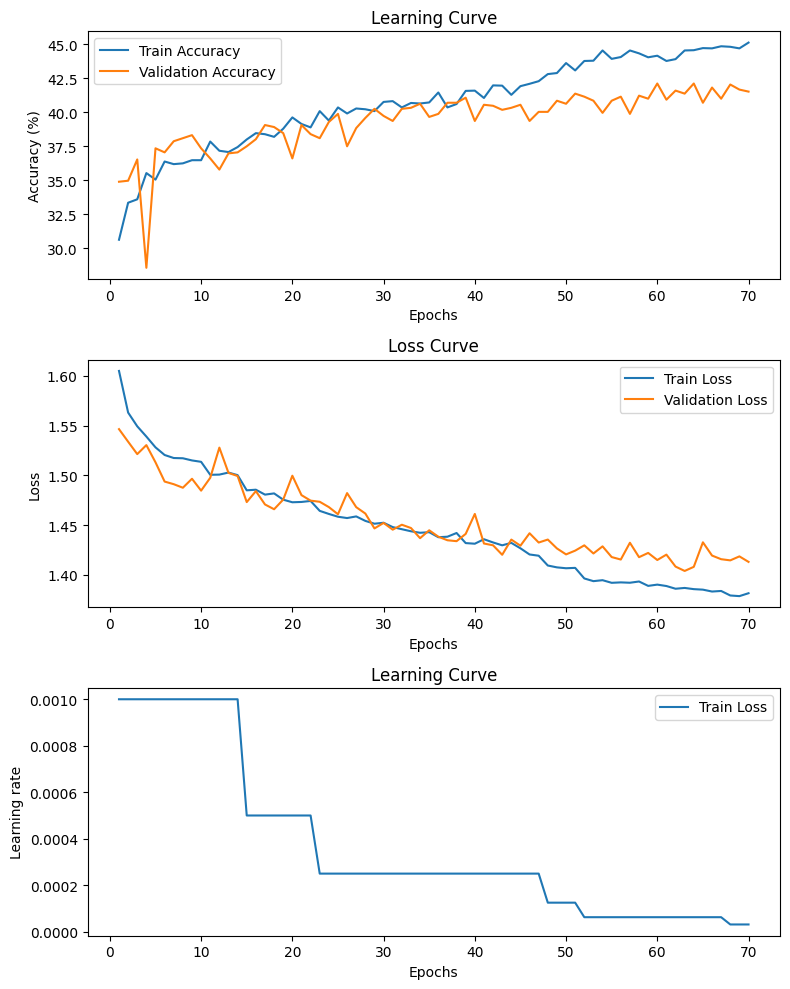

In [65]:
plot_learning_loss(config['epochs'],convnext[1])

In [66]:
print(f"Best accuracy {convnext[0]['acc']}")

Best accuracy 42.11309523809524


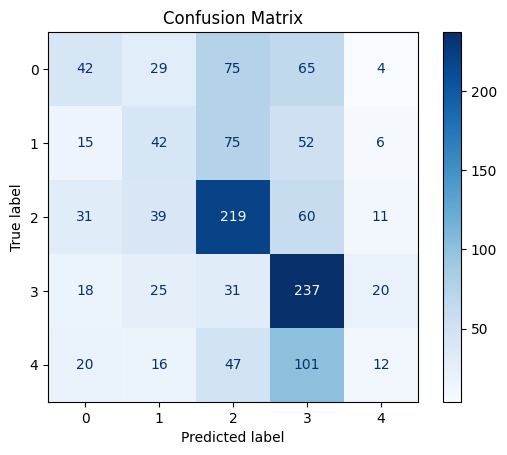

In [67]:
mobilenet_confusion_matrix = plot_confusion_matrix(convnext_small,checkpoint_dir,convnext[0]['epoch'])

# <font color="blue">**D3.2 Observations and Conclusion**</font>

1. **High Performance** : Achieves the accuracy of **42%** among tested models, demonstrating its effective architecture that balances the benefits of both CNNs and transformer-like structures.

1. **Efficient Training Dynamics**:
Exhibits robust training dynamics, with consistent improvements in accuracy, indicating effective learning and generalization capabilities.
Utilizes techniques like stochastic depth for regularization and LayerNorm for faster, more stable convergence.

1. **Complexity and Computation**:
The model is computationally intensive, evidenced by its larger parameter count and significant memory requirements during training.
Despite its complexity, it achieves high accuracy, justifying its design choices in terms of convolutional and transformer integration.

1. **Adaptation to Advanced Features**:
The model progressively adapts to more complex features by expanding the dimensionality and applying deeper transformations, which is crucial for handling diverse and complex datasets effectively.

1. **Potential for Further Tuning**:
Given its architecture, there is potential for further tuning and optimization, particularly in adjusting layer depths, expansion ratios, and regularization techniques to enhance performance or efficiency for specific tasks or datasets.

# <font color = "blue"> Thank you for listening</font>

### Reference:
- Professor Gianni's Lecture Notes
- (Kaiming He et al., 2015) Deep Residual Learning for Image Recognition by Microsoft Research
- (Ningning Ma et al., 2017) ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design
- (Mark Sandler et al., 2017) MobileNetV2: Inverted Residuals and Linear Bottlenecks by Google Research
- (Zhuang Liu et al., 2020) A ConvNet for the 2020s by Facebook AI Research